In [1]:
from pathlib import Path
base = Path.cwd()
if "notebooks" in base.name:
    %cd ..
print(f"Running from path {Path.cwd()}")

/Users/peli/Projects/Repositories/DDM-NumEstPark
Running from path /Users/peli/Projects/Repositories/DDM-NumEstPark


In [2]:
from pathlib import Path
import re
import numpy as np
import pandas as pd
import joblib
import pymc as pm
import pytensor.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import graphviz
import seaborn as sns
from datetime import datetime
from src.model import build_hierarchical_lnlik
from src.utils import get_paths

In [3]:
# Setup
az.style.use("arviz-docgrid") # set arviz style
# setup main vars of interest
# set plot output dir
model_name = "model_1"
plot_dir = Path("plots") / model_name
plot_dir.mkdir(exist_ok=True)
# save plot function

In [4]:
def get_sub_paths():
    """
    Return a list of all file paths of csv data
    """
    dir = "data"
    base = Path.cwd()
    data_dir = base / dir
    data_files = list(data_dir.glob('*.csv'))
    print(f"data_files {data_files}")
    return data_files

def get_subject_data():
    files = get_sub_paths()
    file = files[0]
    df = pd.read_csv(file)
    print(df.head(5))
    subject_df = df[df["S_ID"] == "S_00"]

    x_stim = subject_df["Presented_numerosity"]
    y_obs = subject_df["Estimated_numerosity"]

    print(f"Length n_stim {len(x_stim)}")
    print(f"n_stim: {x_stim.value_counts().sort_index()}")
    print(f"Length y_obs {len(y_obs)}")
    print(f"y_obs: {y_obs.value_counts().sort_index()}")
    return x_stim, y_obs

def get_all_data(
        subset_prop: float | None = None
):
    path = get_paths("dataset", "*")

    df = pd.read_csv(path)
    

    if subset_prop:
        assert 0 < subset_prop < 1
        np.random.seed(89)
        # Get unique subject IDs
        unique_subjects = df["S_ID"].unique()
        # Randomly sample ~20% of subjects
        n_subset = max(1, int(subset_prop * len(unique_subjects)))  # at least 1 subject
        sampled_subjects = np.random.choice(
            unique_subjects, 
            size=n_subset, 
            replace=False
        )
        # Filter dataframe to only those subjects
        df = df[df["S_ID"].isin(sampled_subjects)].reset_index(drop=True)

    X = df
    

    return X



In [5]:
# Load data
X = get_all_data()

# Encode hallucination group as Categorical (trial-level, but will extract per subject)
X["s_param_ph"] = X["s_param_ph"].replace({"1mh": "3mhch"})
order = ['0nh', '3mhch']
X["s_param_ph"] = pd.Categorical(X["s_param_ph"], categories=order, ordered=True)

# 1. Count UNIQUE subjects per hallucination group
subject_groups = X.drop_duplicates("S_ID")[["S_ID", "s_param_ph"]]
group_counts = subject_groups["s_param_ph"].value_counts().reindex(order, fill_value=0)
print("Number of subjects per hallucination group (s_param_ph):")
print(group_counts)
print()

# Number of unique participants
n_subjects_total = X["S_ID"].nunique()
print(f"Total number of unique subjects: {n_subjects_total}")

# Presented simtuli and estimated stimuli statistics
x_min = X["Presented_numerosity"].min()
x_max = X["Presented_numerosity"].max()
print(f"Presented numerosity Min: {x_min} Max: {x_max}")
y_min = X["Estimated_numerosity"].min()
y_max = X["Estimated_numerosity"].max()
y_mean = X["Estimated_numerosity"].mean()
print(f"Estimated numerosity Min: {y_min} Max: {y_max} Mean: {y_mean}")


data_files [PosixPath('/Users/peli/Projects/Repositories/DDM-NumEstPark/dataset/study2.csv')]
unpacked list
Number of subjects per hallucination group (s_param_ph):
s_param_ph
0nh      55
3mhch    63
Name: count, dtype: int64

Total number of unique subjects: 118
Presented numerosity Min: 5 Max: 8
Estimated numerosity Min: -11 Max: 112 Mean: 7.66207627118644


Remaining rows: 9361


(array([1.488e+03, 3.715e+03, 1.665e+03, 1.610e+03, 1.800e+02, 3.960e+02,
        8.400e+01, 1.600e+02, 6.000e+00, 3.400e+01, 1.000e+01, 5.000e+00,
        2.000e+00, 3.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 4.        ,  5.53333333,  7.06666667,  8.6       , 10.13333333,
        11.66666667, 13.2       , 14.73333333, 16.26666667, 17.8       ,
        19.33333333, 20.86666667, 22.4       , 23.93333333, 25.46666667,
        27.        , 28.53333333, 30.06666667, 31.6       , 33.13333333,
        34.66666667, 36.2       , 37.73333333, 39.26666667, 40.8       ,
        42.33333333, 43.86666667, 45.4       , 46.93333333, 48.46666667,
        50.        ]),
 <BarContainer object of 30 artists>)

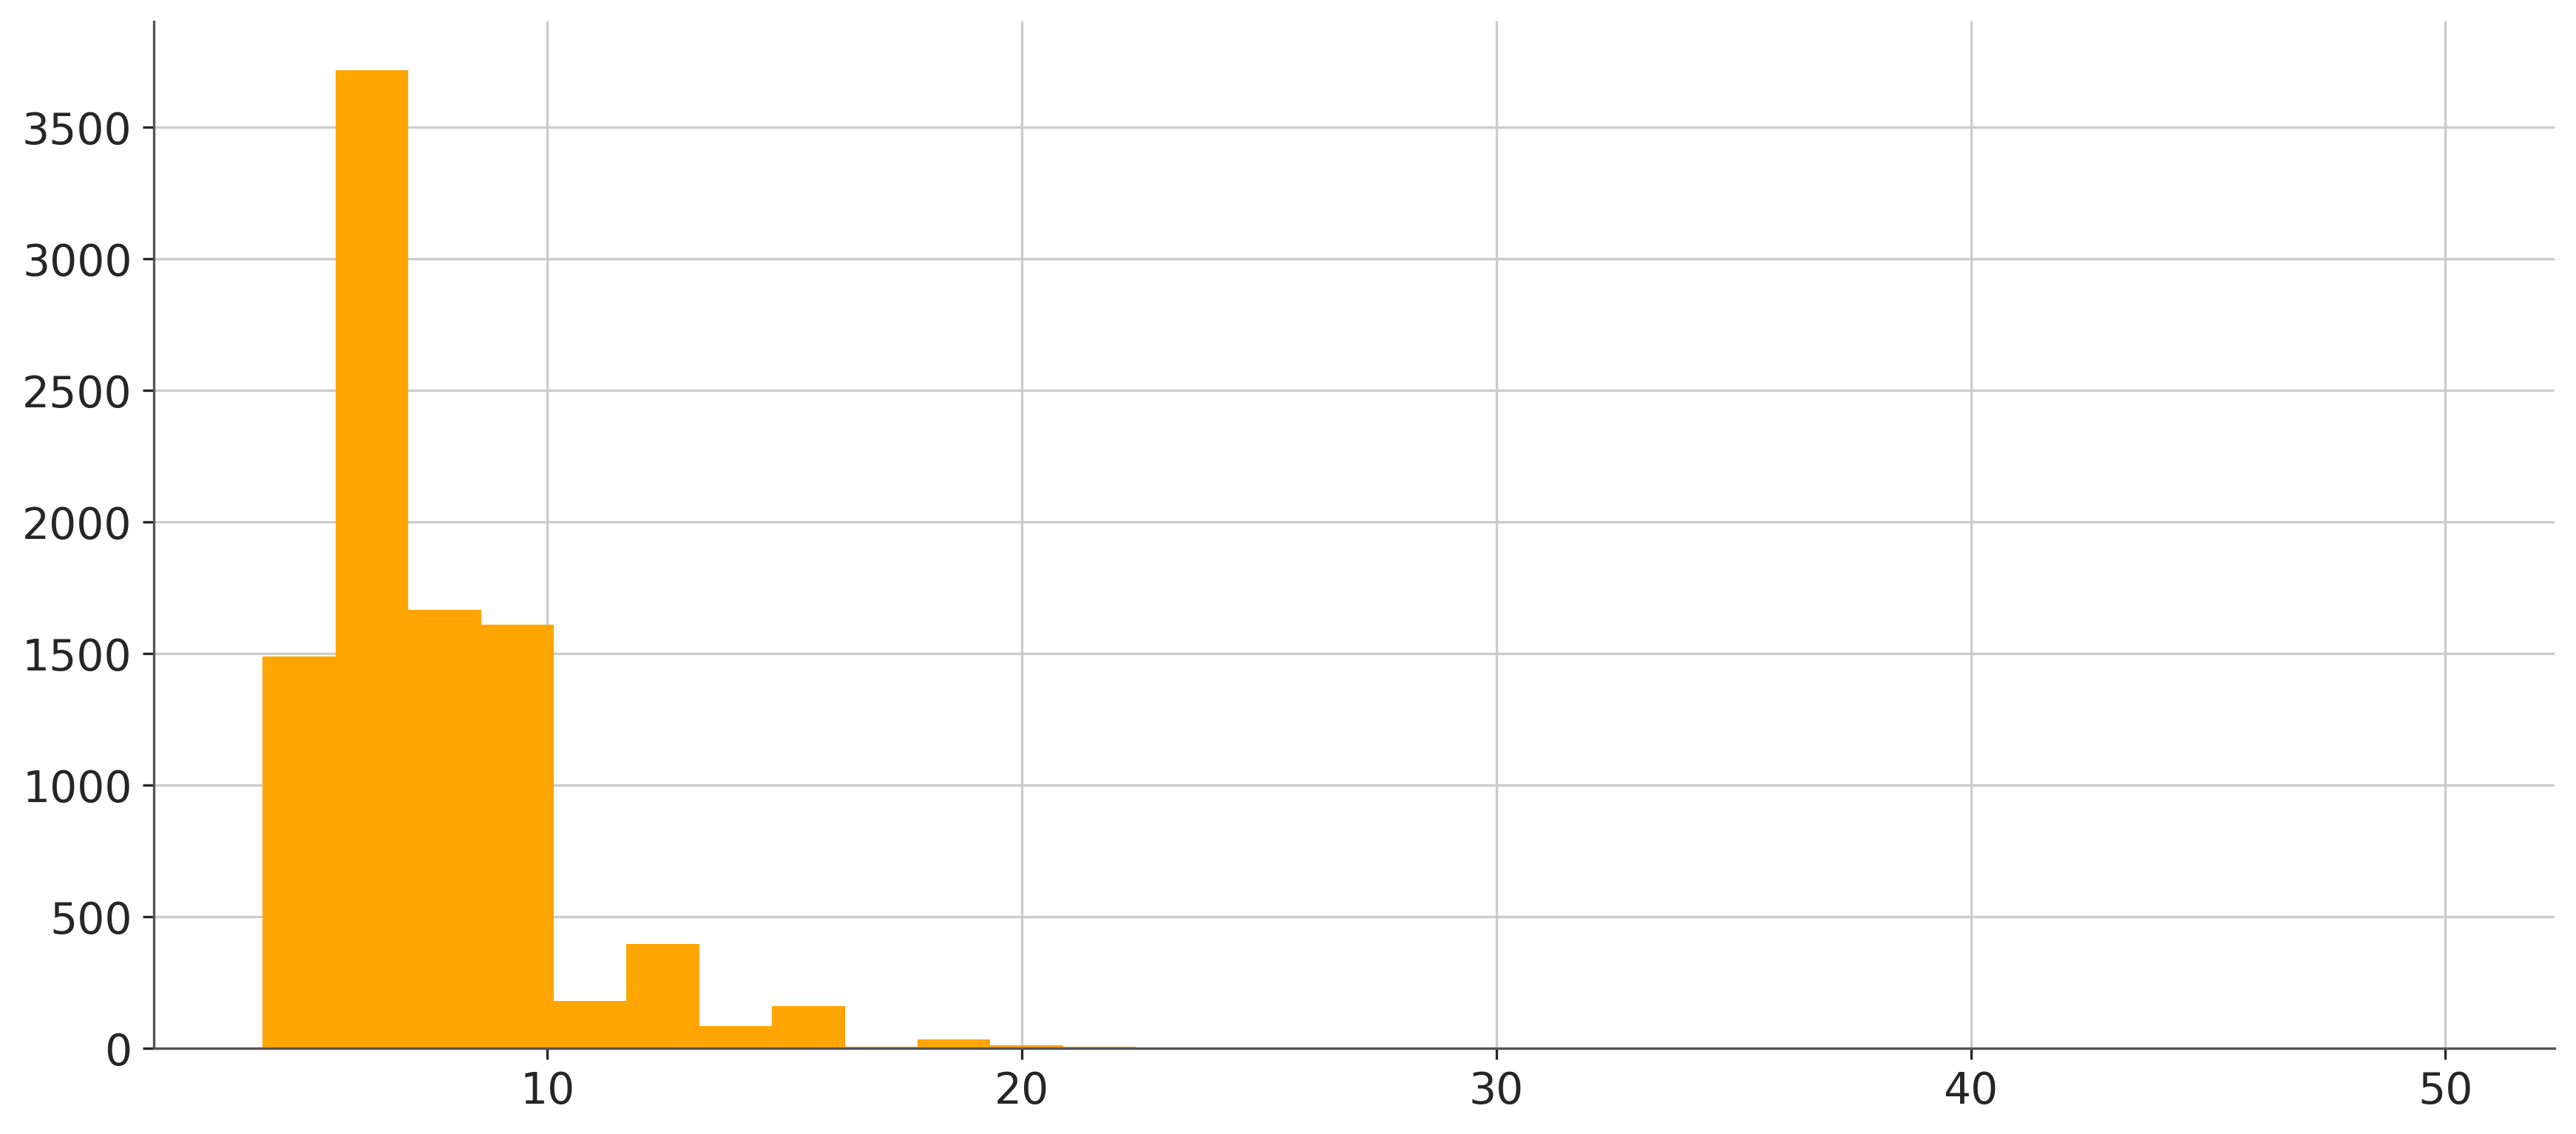

In [6]:
# remove rows where Estimated_numerosity > 24
X = X[X["Estimated_numerosity"].between(4, 50)].copy()

# optional: check result
print(f"Remaining rows: {len(X)}")
plt.hist(X["Estimated_numerosity"], bins=30, color="orange")

In [7]:

# Encode entity (trial-level)
entity, entity_labels = pd.factorize(X["entity"])  # shape (n_trials,)
print(entity)

# Extract trial-level numerosity
x_stim = X["Presented_numerosity"].values
y_obs = X["Estimated_numerosity"].values
dose = X["dose"].values

# --- Build subject-level mapping ---
subject_info = X.drop_duplicates("S_ID").sort_values("S_ID")

# Map original S_ID → 0-based integer index (for PyMC)
subject_id_map = {subj: idx for idx, subj in enumerate(subject_info["S_ID"])}
subject_id = X["S_ID"].map(subject_id_map).values.astype(int)  # shape (n_trials,) → ✅ REPEATS ARE OK

# ✅ CORRECT: extract integer group codes at SUBJECT level
ph_type = subject_info["s_param_ph"].cat.codes.values  # shape (n_subjects,), dtype=int

# Optional: sanity checks
assert len(ph_type) == len(subject_info), "Group codes must be per subject"
assert subject_id.max() == len(ph_type) - 1, "subject_id must align with group codes"
assert set(np.unique(ph_type)) <= {0, 1, 2}, "Invalid group codes"

print(f"subject_id {len(subject_id)}")
print(f"ph_type {len(ph_type)}")

[0 0 0 ... 1 1 1]
subject_id 9361
ph_type 118


In [8]:
print(f"Building model ...")
model = build_hierarchical_lnlik(
    x_stim,
    y_obs,
    subject_id,
    ph_type,
    entity
)

sample_config = {
    "draws": 4000,
    "tune": 2000,
    "target_accept": 0.9,
    "chains": 4,
    "random_seed": 94
}


Building model ...


Sampling: [beta_mu, beta_sigma, beta_subj, log_alpha_mu, log_alpha_sigma, log_alpha_subj, sigma_group, y]


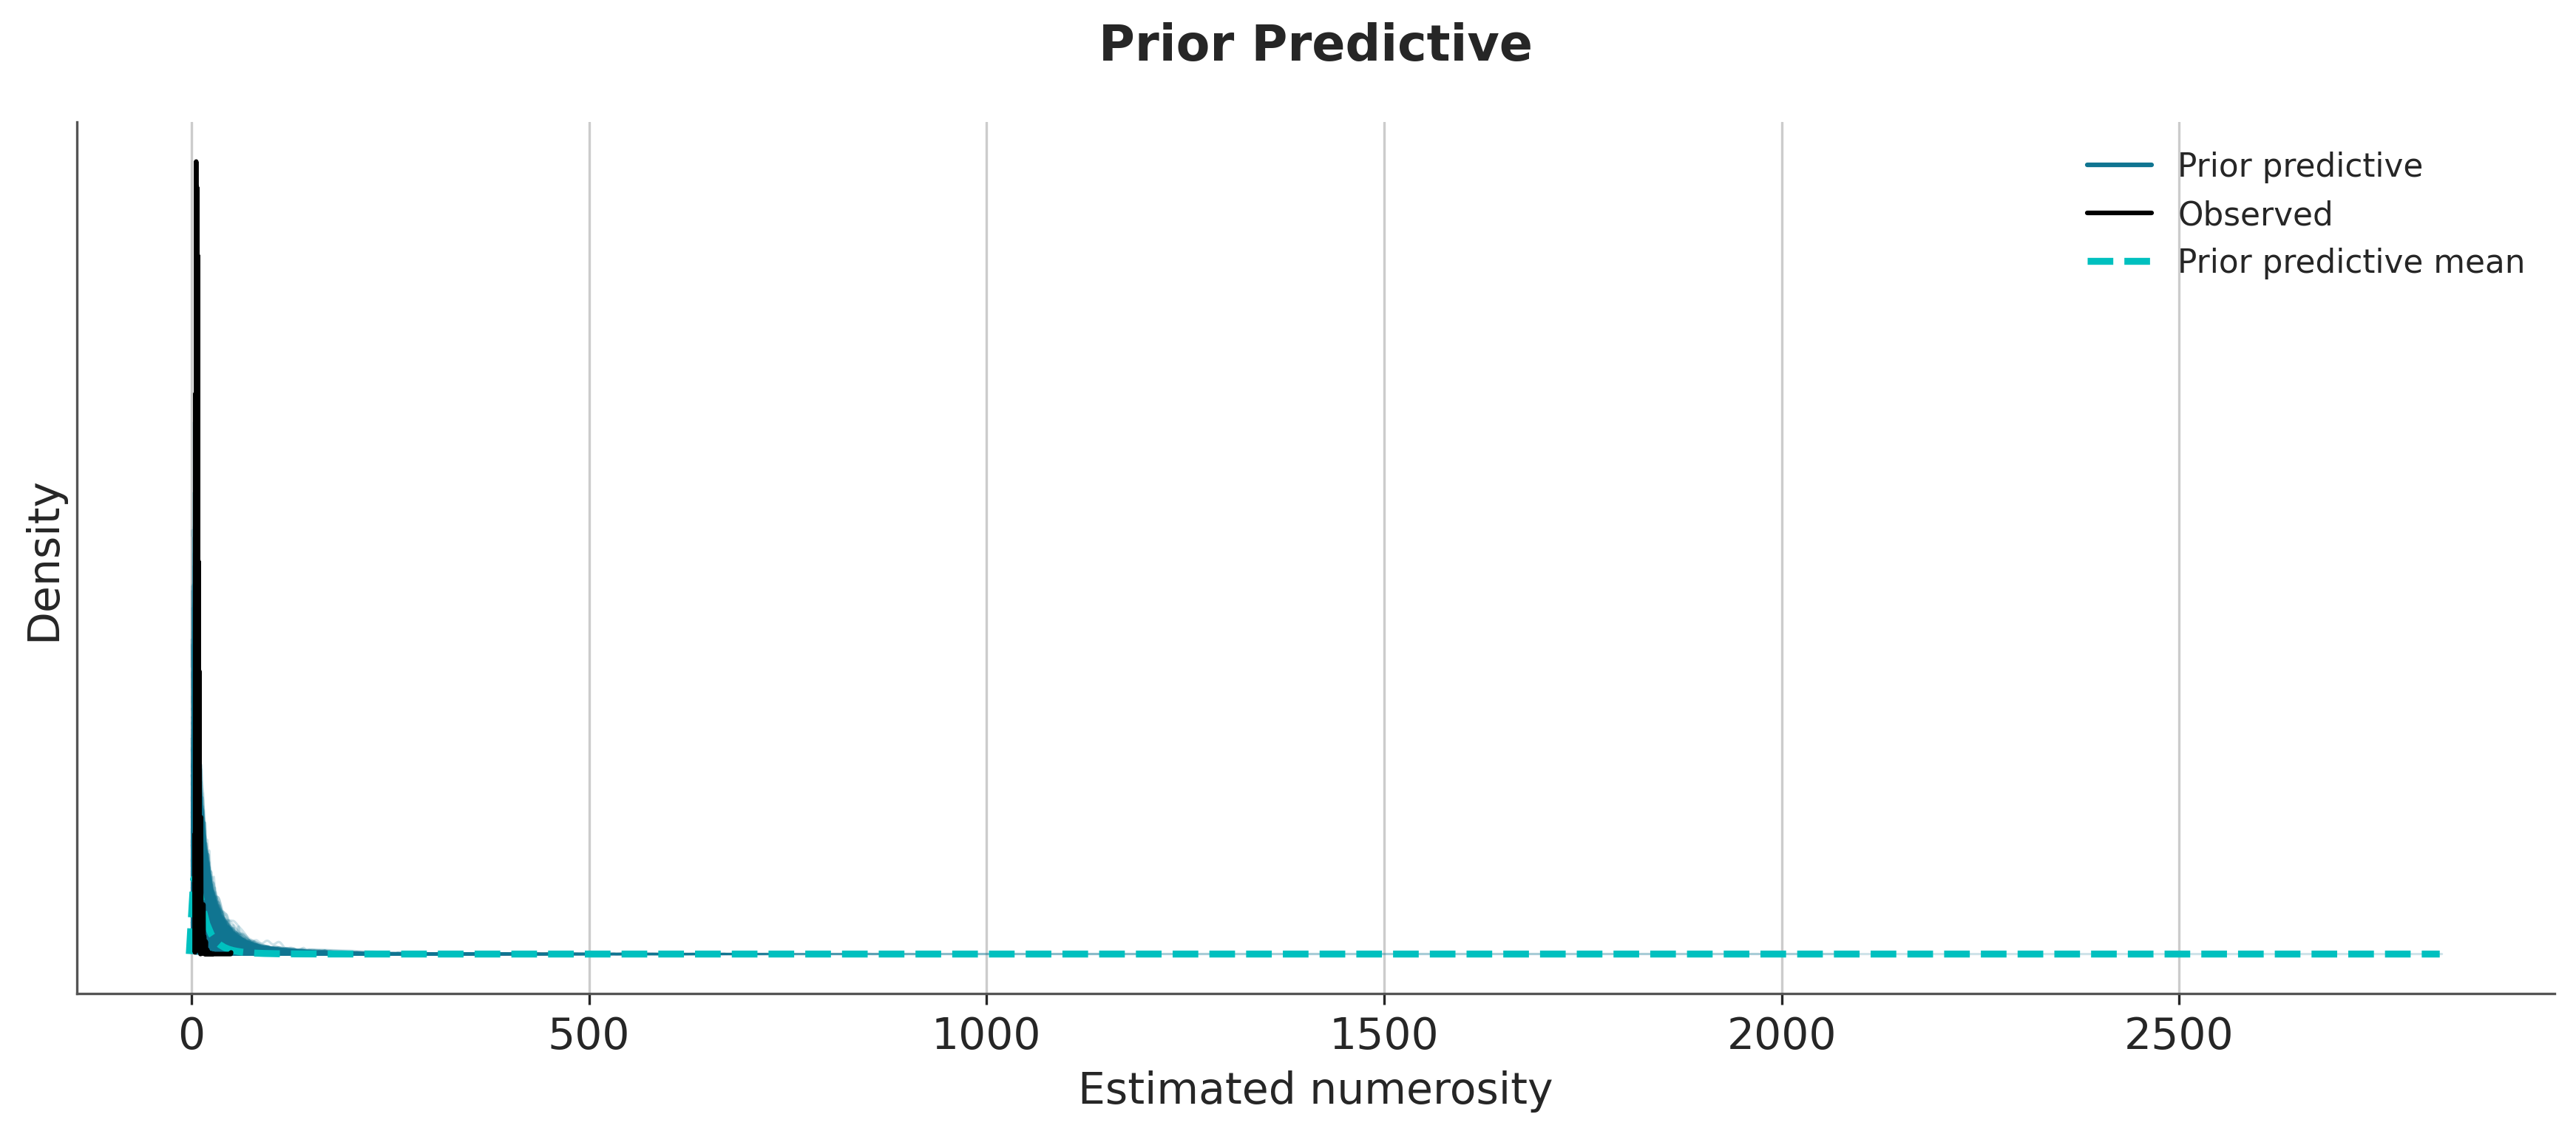

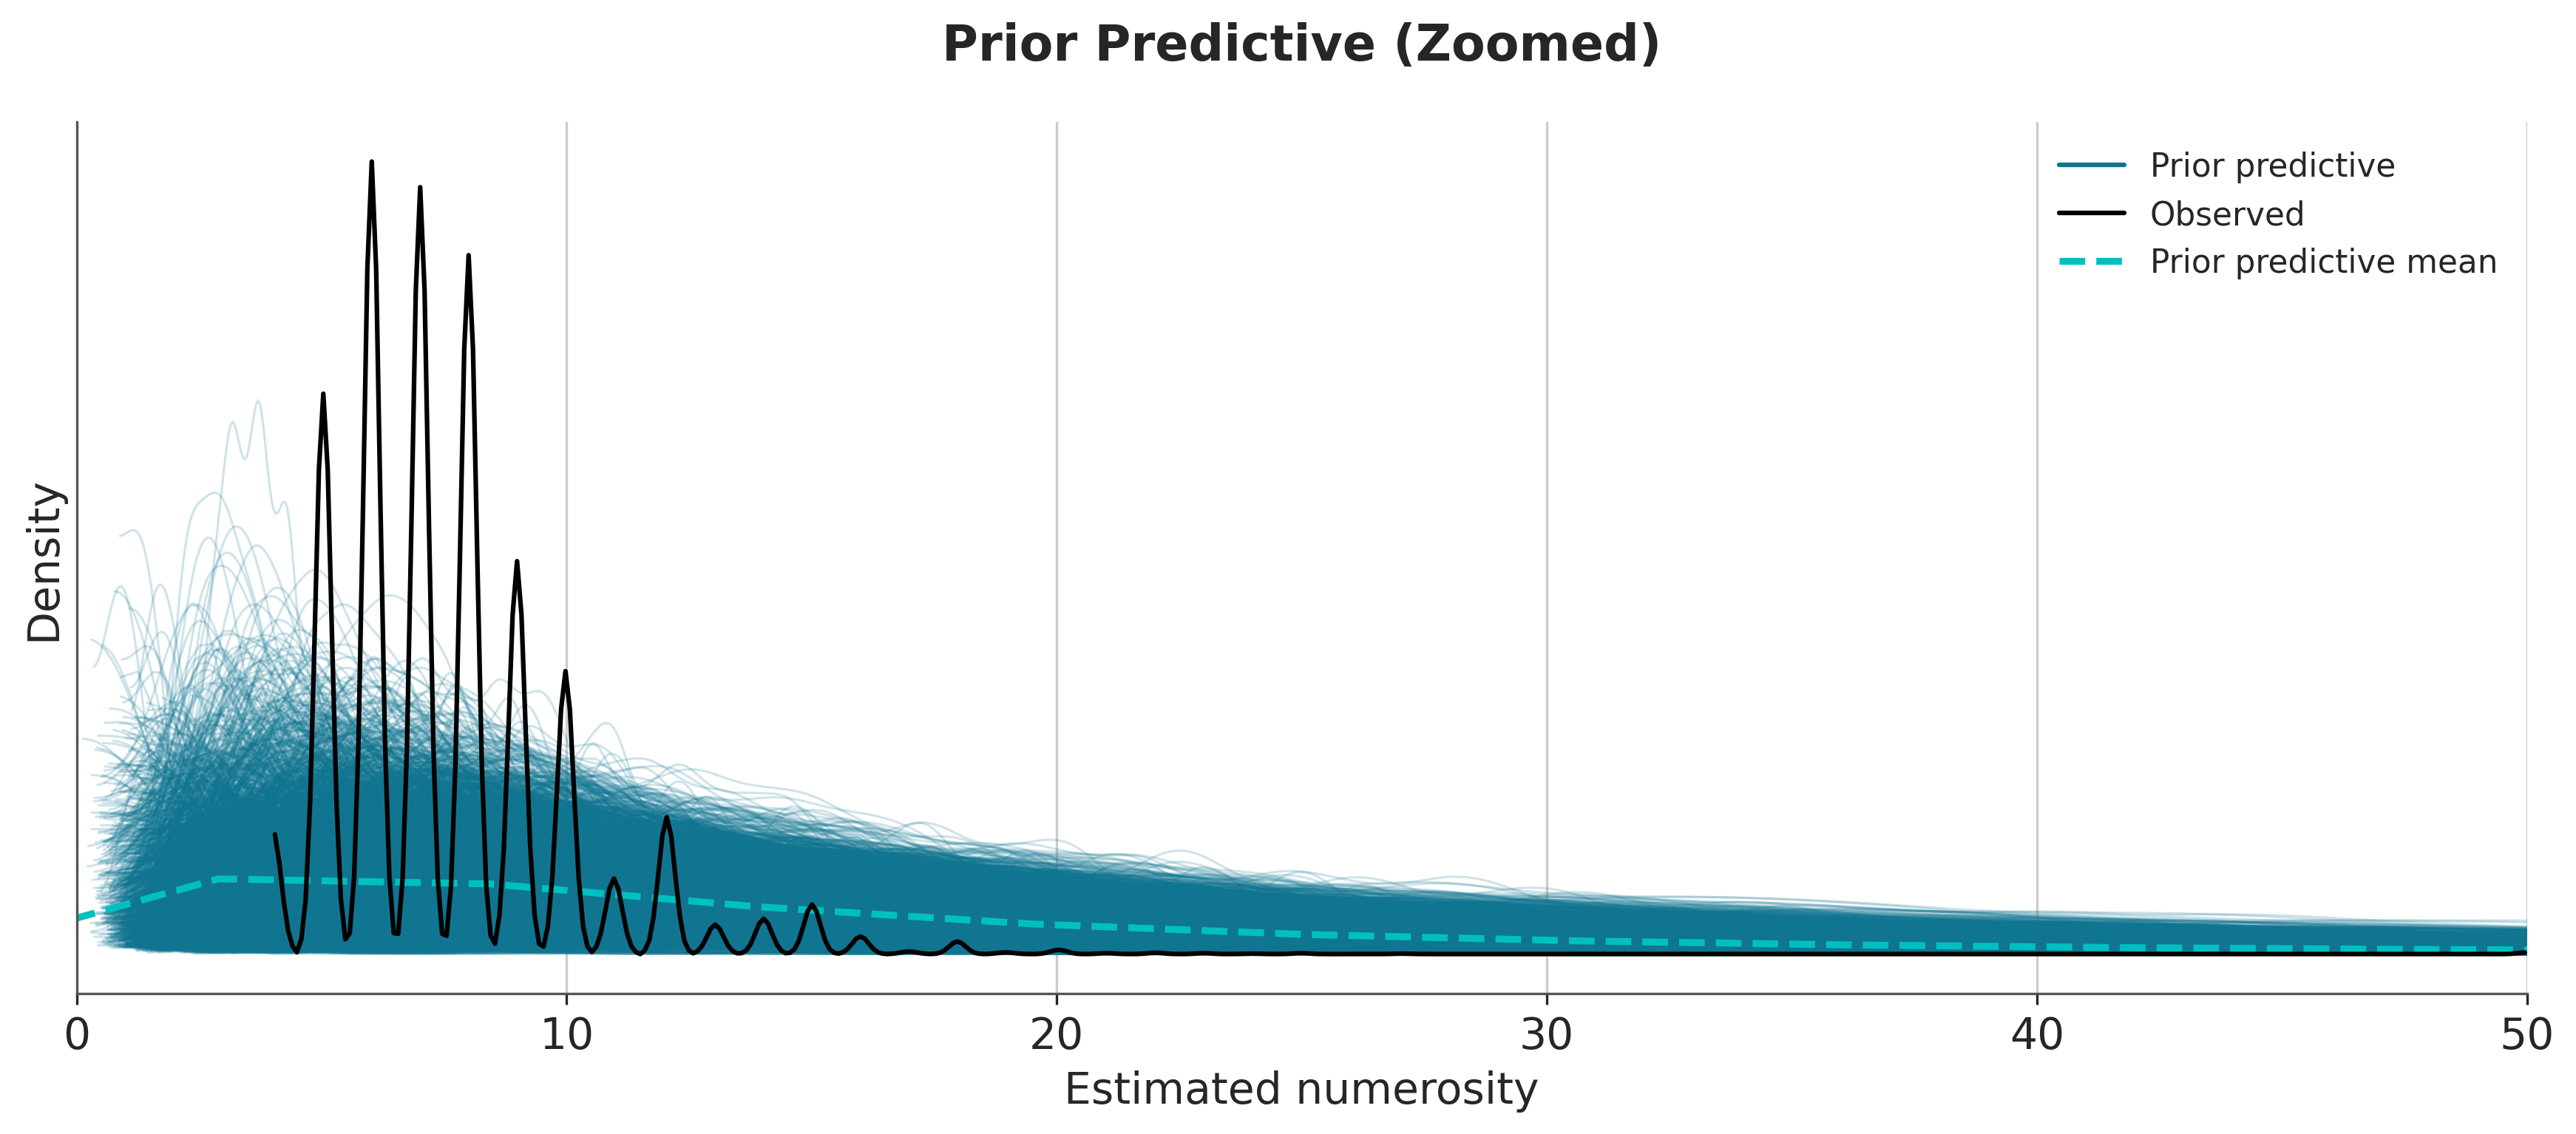

In [9]:
# sanity prior-predictive check
with model:
    prior_pred = pm.sample_prior_predictive(
        samples=5000,
        var_names=["y","y_pred"],
        random_seed=23
    )

    
axes = az.plot_ppc(prior_pred, group="prior", observed="y")
axes.set_title("Prior Predictive", y=1.05)
axes.set_xlabel("Estimated numerosity")
axes.set_ylabel("Density")
fig = axes.figure
fig.savefig(plot_dir/"prior_pred_full.png")

axes_zoom = az.plot_ppc(prior_pred, group="prior", observed="y")
axes_zoom.set_xlim([0,50])
axes_zoom.set_title("Prior Predictive (Zoomed)", y=1.05)
axes_zoom.set_xlabel("Estimated numerosity")
axes_zoom.set_ylabel("Density")

# Save figure
fig = axes_zoom.figure  # get figure from axes
fig.savefig(plot_dir/"prior_pred_zoom.png")

In [ ]:
# Sampling
with model:

    trace = pm.sample(**sample_config)

    post_pred = pm.sample_posterior_predictive(
        trace, 
        var_names=["y", "y_pred"],
        random_seed=844
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_alpha_mu, log_alpha_sigma, log_alpha_subj, beta_mu, beta_sigma, beta_subj, sigma_group]


Output()

In [ ]:
trace.extend(prior_pred)
trace.extend(post_pred)
idata = trace
idata

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [ ]:
main_vars = ["log_alpha_mu", "log_alpha_sigma", "beta_mu", "beta_sigma", "sigma_group"]

In [ ]:
# TODO: save idata object here

## Convergence & Sampling Diagnostics

In [ ]:

# Basic diagnostics
az.summary(idata, var_names=main_vars, round_to=2)


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log_alpha_mu[NH, object]     0.31  0.04    0.24     0.38        0.0      0.0   
log_alpha_mu[NH, human]      0.17  0.04    0.09     0.26        0.0      0.0   
log_alpha_mu[PH, object]     0.24  0.04    0.18     0.31        0.0      0.0   
log_alpha_mu[PH, human]     -0.00  0.07   -0.13     0.13        0.0      0.0   
log_alpha_sigma[NH, object]  0.09  0.03    0.04     0.15        0.0      0.0   
log_alpha_sigma[NH, human]   0.20  0.08    0.07     0.35        0.0      0.0   
log_alpha_sigma[PH, object]  0.08  0.03    0.02     0.13        0.0      0.0   
log_alpha_sigma[PH, human]   0.47  0.06    0.36     0.58        0.0      0.0   
beta_mu[NH, object]          0.86  0.02    0.82     0.90        0.0      0.0   
beta_mu[NH, human]           1.00  0.03    0.95     1.04        0.0      0.0   
beta_mu[PH, object]          0.91  0.02    0.87     0.95        0.0      0.0   
beta_mu[PH, human]           1.12  0.04    1.05     1.18        0.0      0.0   
beta_sigma[NH, object]       0.07  0.01    0.05     0.09        0.0      0.0   
beta_sigma[NH, human]        0.13  0.04    0.07     0.20        0.0      0.0   
beta_sigma[PH, object]       0.07  0.01    0.05     0.09        0.0      0.0   
beta_sigma[PH, human]        0.28  0.03    0.22     0.33        0.0      0.0   
sigma_group[NH]              0.15  0.00    0.15     0.16        0.0      0.0   
sigma_group[PH]              0.16  0.00    0.16     0.16        0.0      0.0   

                             ess_bulk  ess_tail  r_hat  
log_alpha_mu[NH, object]      2067.86   4474.25    1.0  
log_alpha_mu[NH, human]       7257.76   9097.60    1.0  
log_alpha_mu[PH, object]      1506.59   2958.28    1.0  
log_alpha_mu[PH, human]      17259.57  12128.49    1.0  
log_alpha_sigma[NH, object]   1111.21    847.88    1.0  
log_alpha_sigma[NH, human]     603.43   1380.29    1.0  
log_alpha_sigma[PH, object]    499.55    370.87    1.0  
log_alpha_sigma[PH, human]    7510.15   9708.20    1.0  
beta_mu[NH, object]           2350.28   5073.30    1.0  
beta_mu[NH, human]            7871.54  10626.64    1.0  
beta_mu[PH, object]           1679.58   2965.46    1.0  
beta_mu[PH, human]           16245.44  11688.47    1.0  
beta_sigma[NH, object]        6046.86   7963.93    1.0  
beta_sigma[NH, human]          689.30   4149.47    1.0  
beta_sigma[PH, object]        2936.85   1712.69    1.0  
beta_sigma[PH, human]         8102.32   9969.01    1.0  
sigma_group[NH]               2296.80   6433.68    1.0  
sigma_group[PH]              13591.30  10890.22    1.0

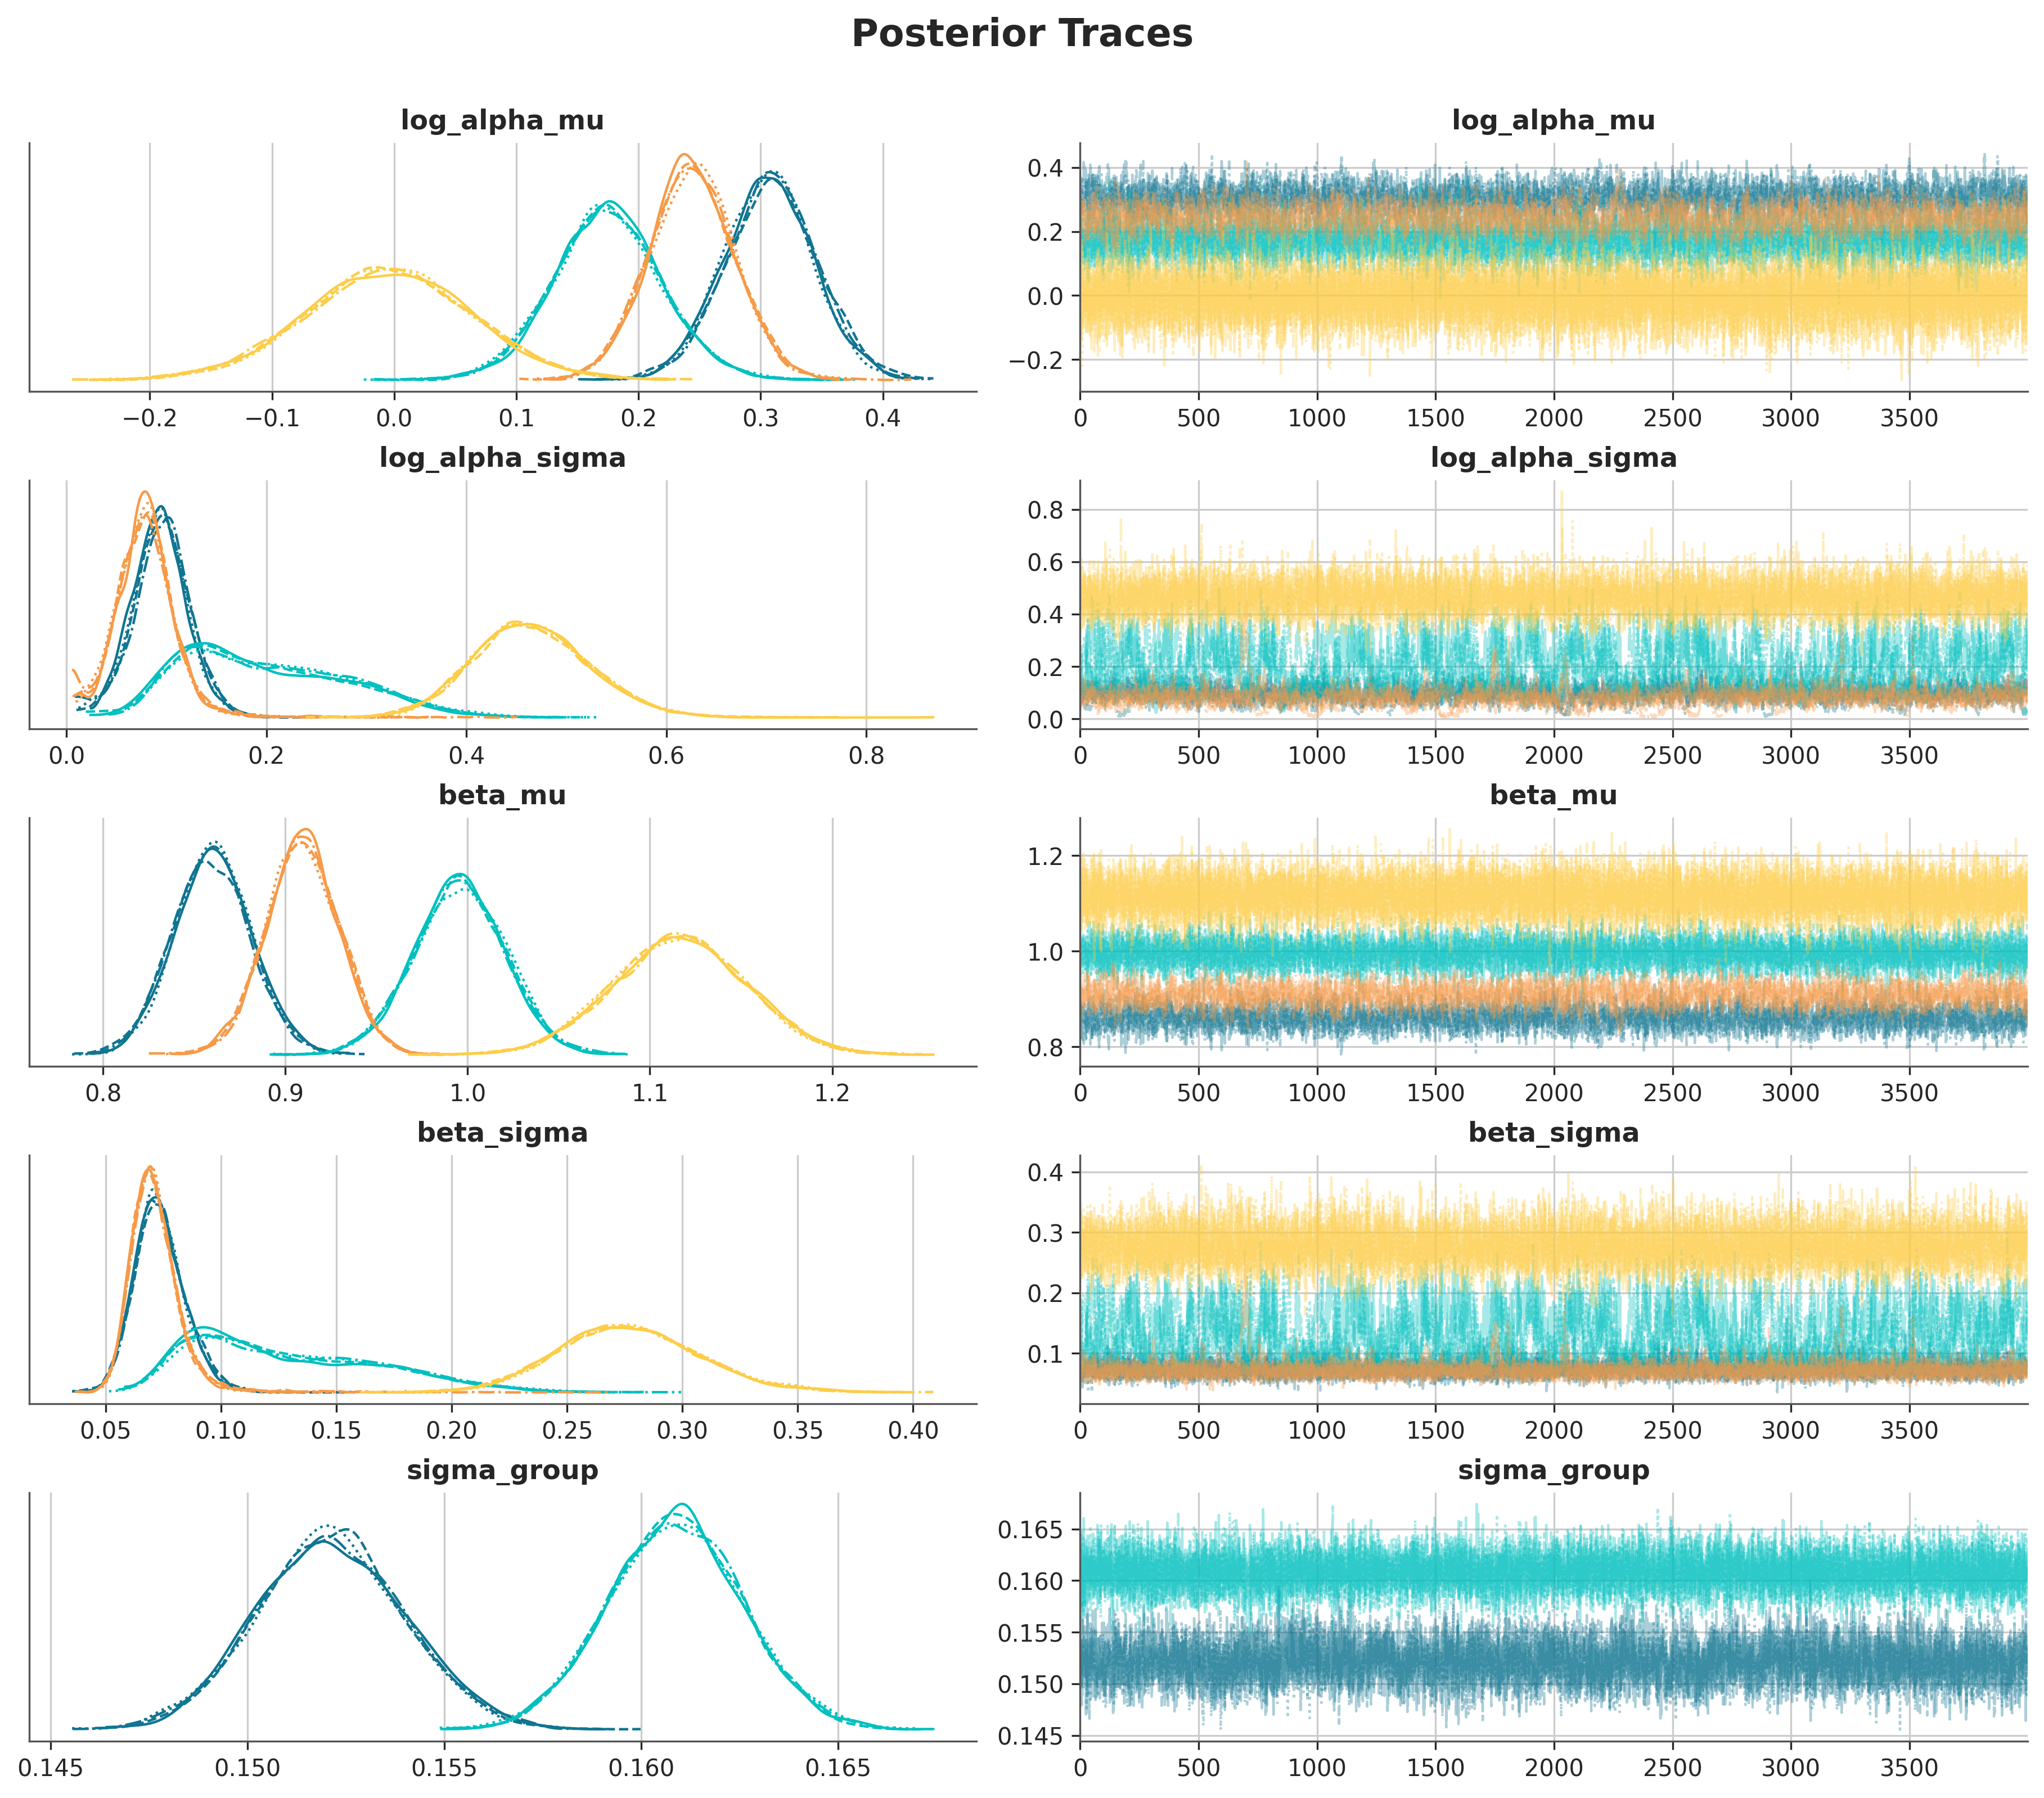

In [ ]:
# Trace plots
trace_plot = az.plot_trace(idata, var_names=main_vars)
# axes is your array of Axes
fig = trace_plot[0, 0].figure  # get the figure from the first subplot

# Add a main title
fig.suptitle("Posterior Traces", fontsize=16, y=1.05)  # y>1 moves it up

fig.savefig(plot_dir/"trace_plot.png")

## Posterior Predictive

<Axes: xlabel='y / y_pred'>

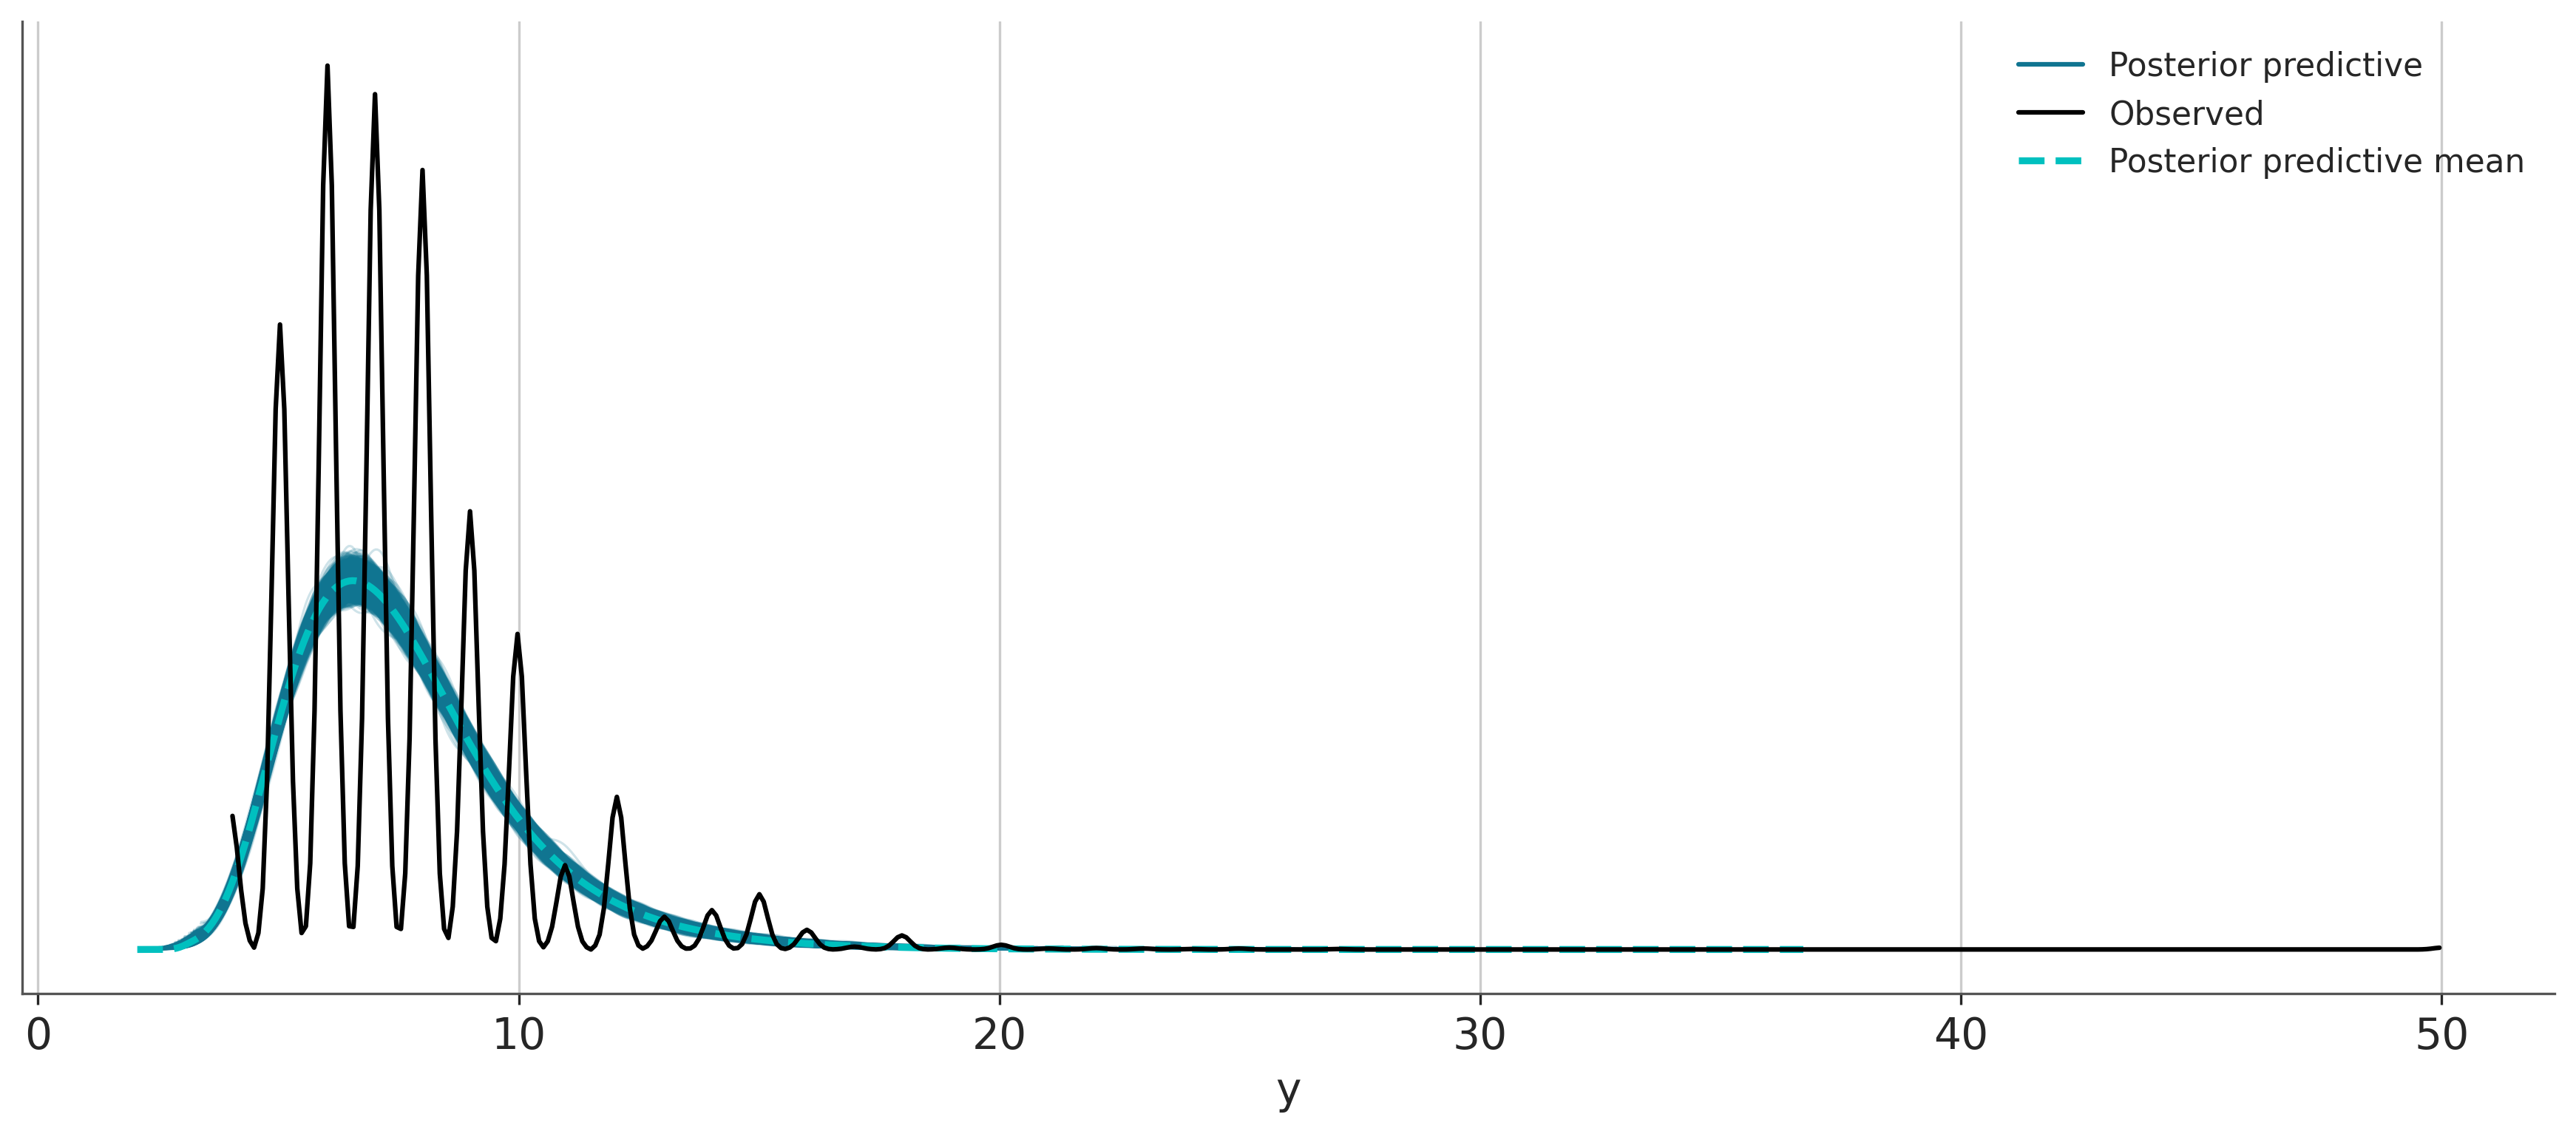

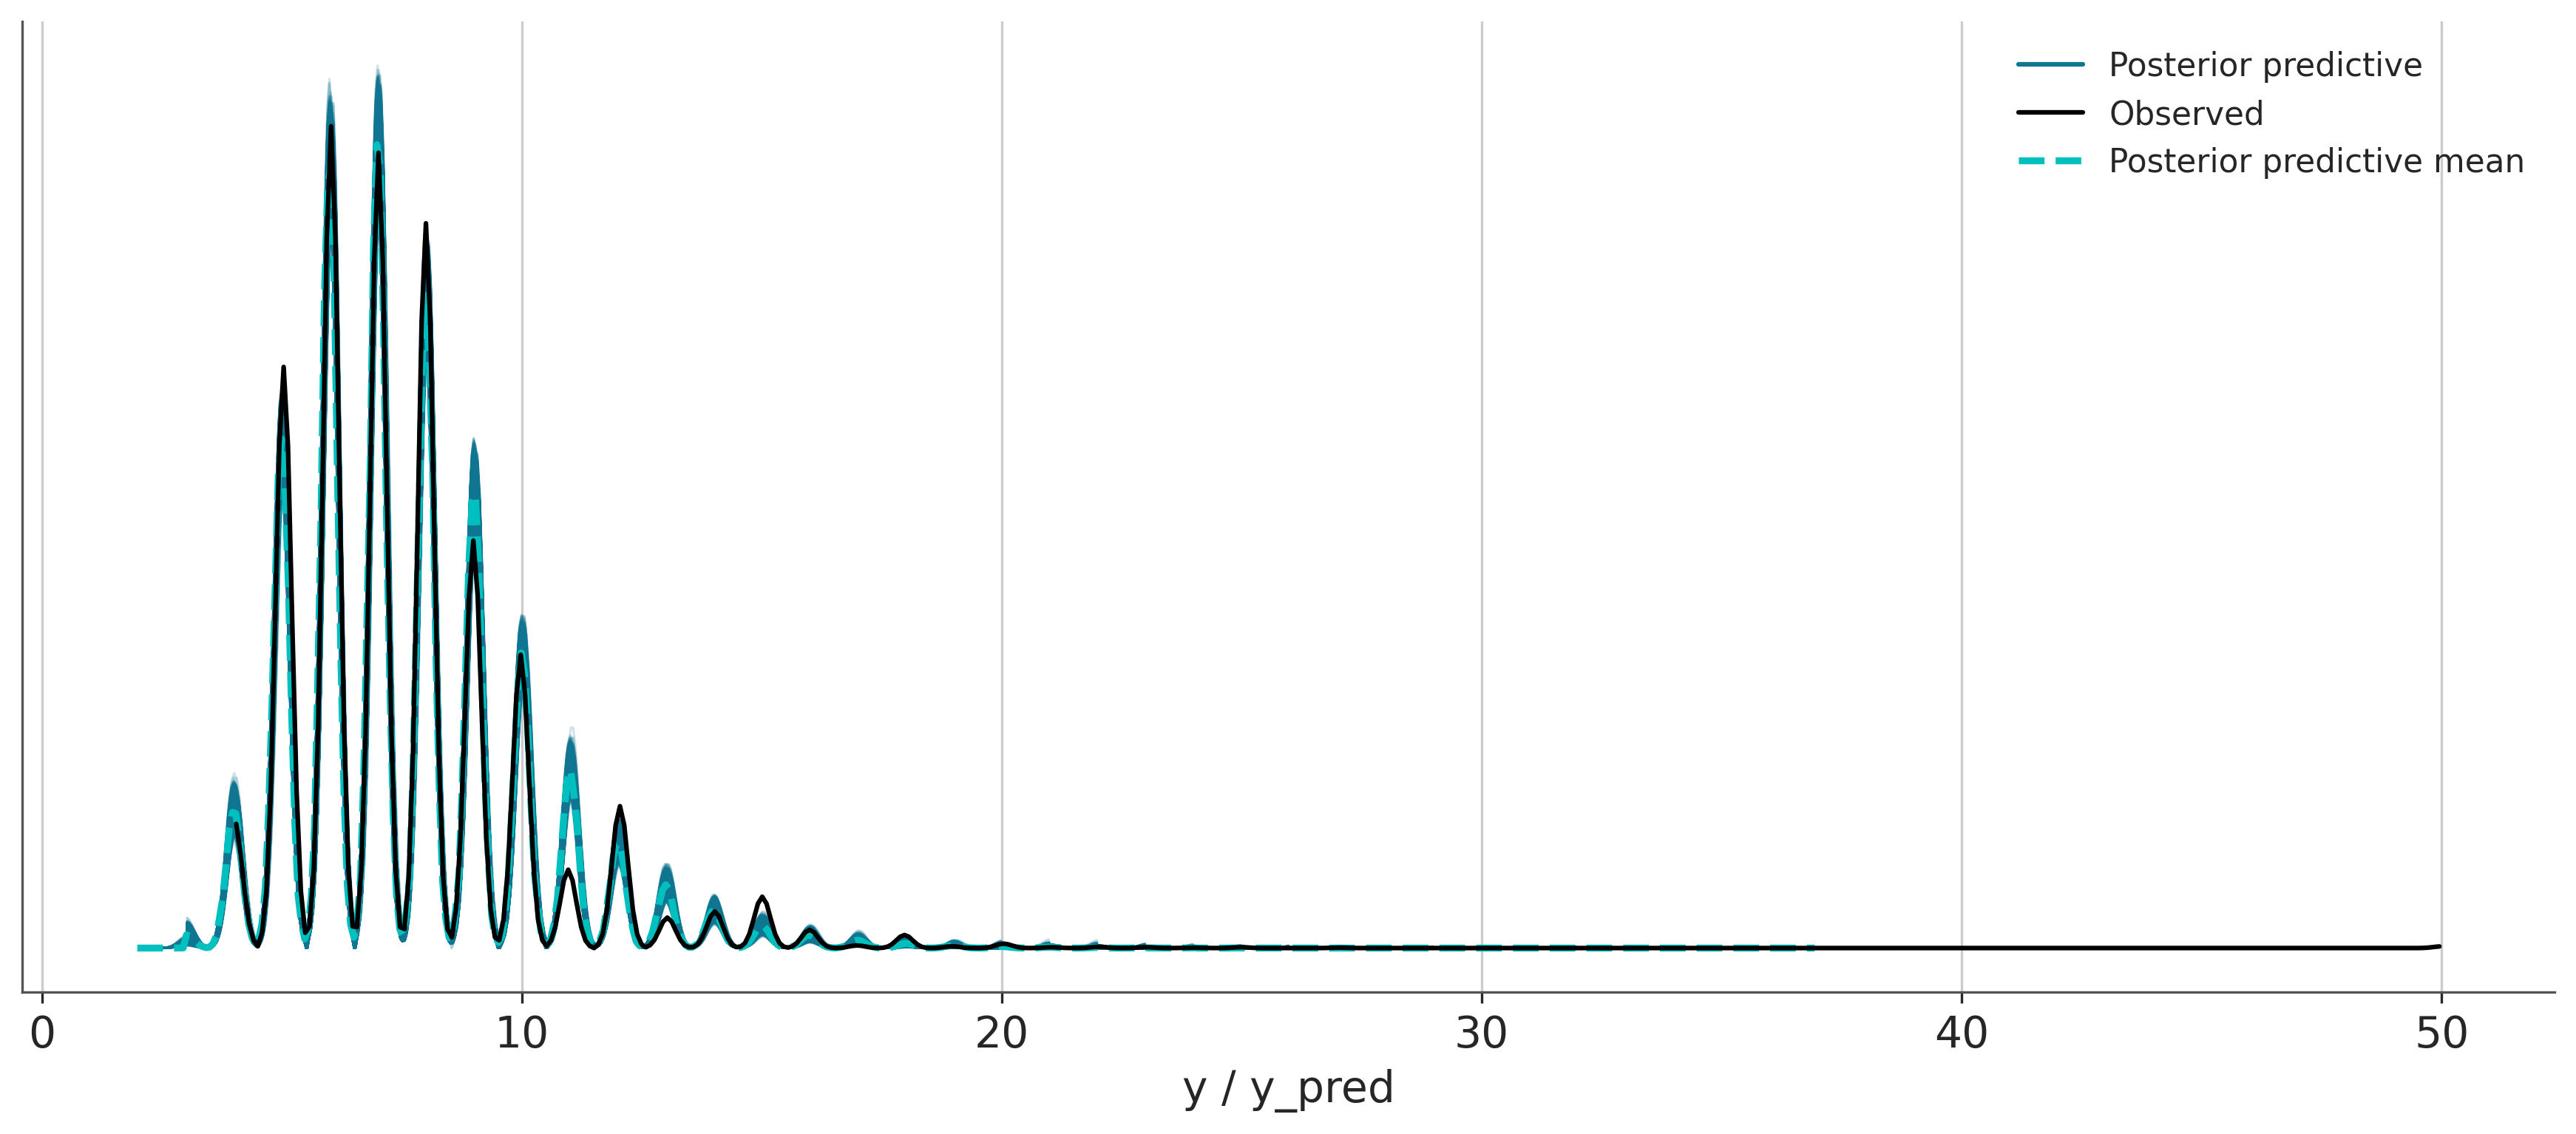

In [ ]:
az.plot_ppc(idata)
az.plot_ppc(idata, data_pairs={"y":"y_pred"})

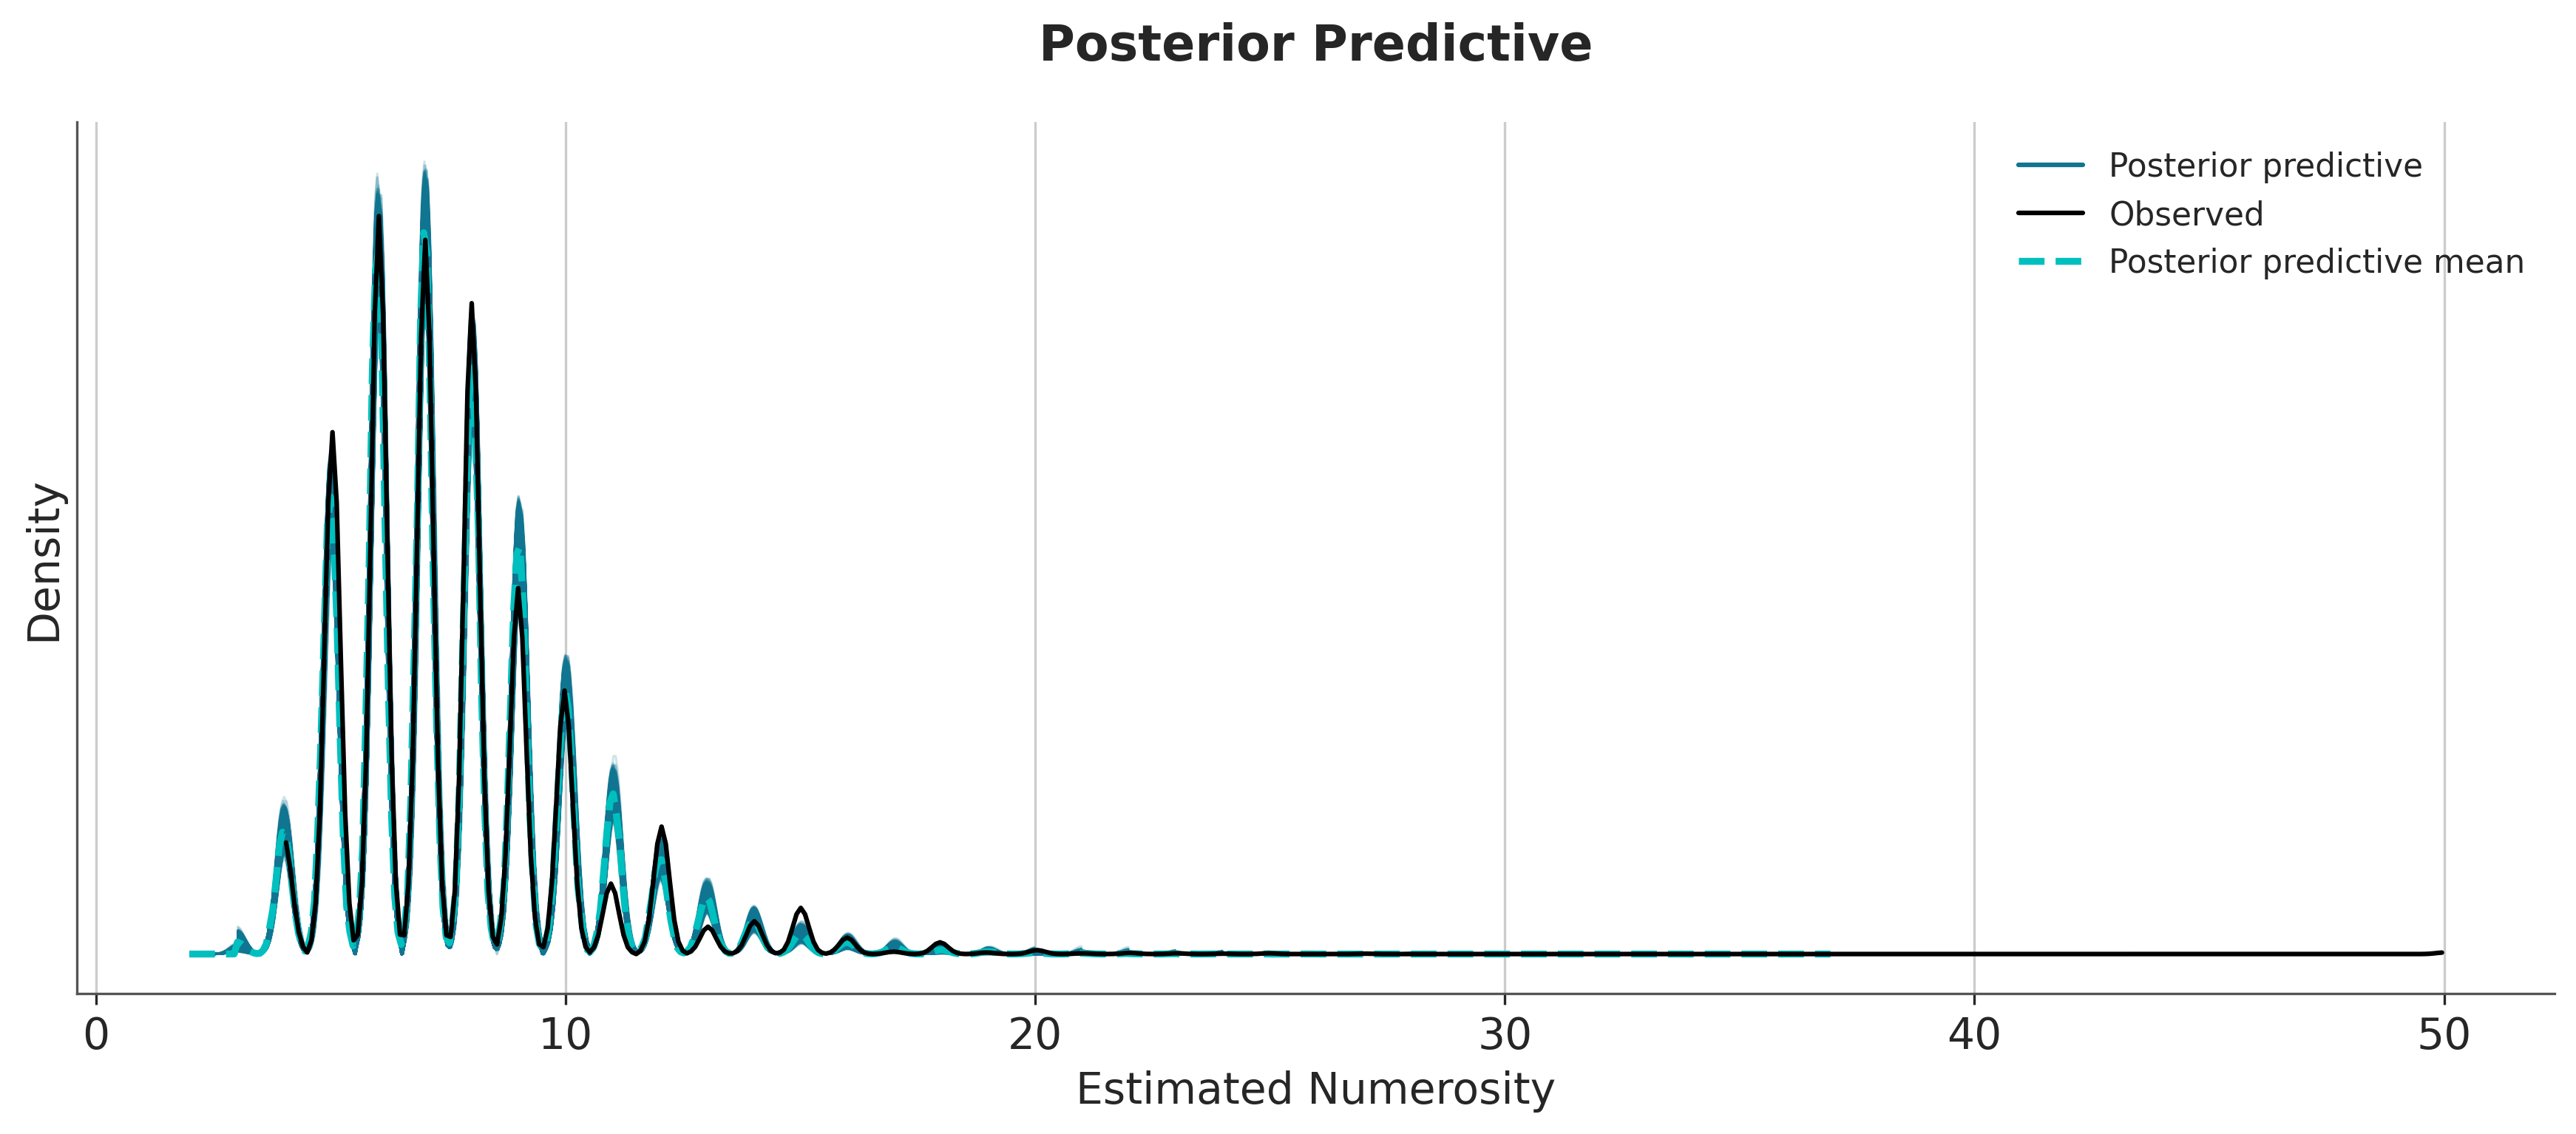

In [ ]:
axes = az.plot_ppc(idata, data_pairs={"y":"y_pred"})

# Set title and x-label
axes.set_title("Posterior Predictive", y=1.05)
axes.set_xlabel("Estimated Numerosity")
axes.set_ylabel("Density")

# Save figure
post_pred_ = axes.figure  # get figure from axes
fig.savefig(plot_dir/"post_pred.png")


## Posterior Summaries of Key Group Parameters


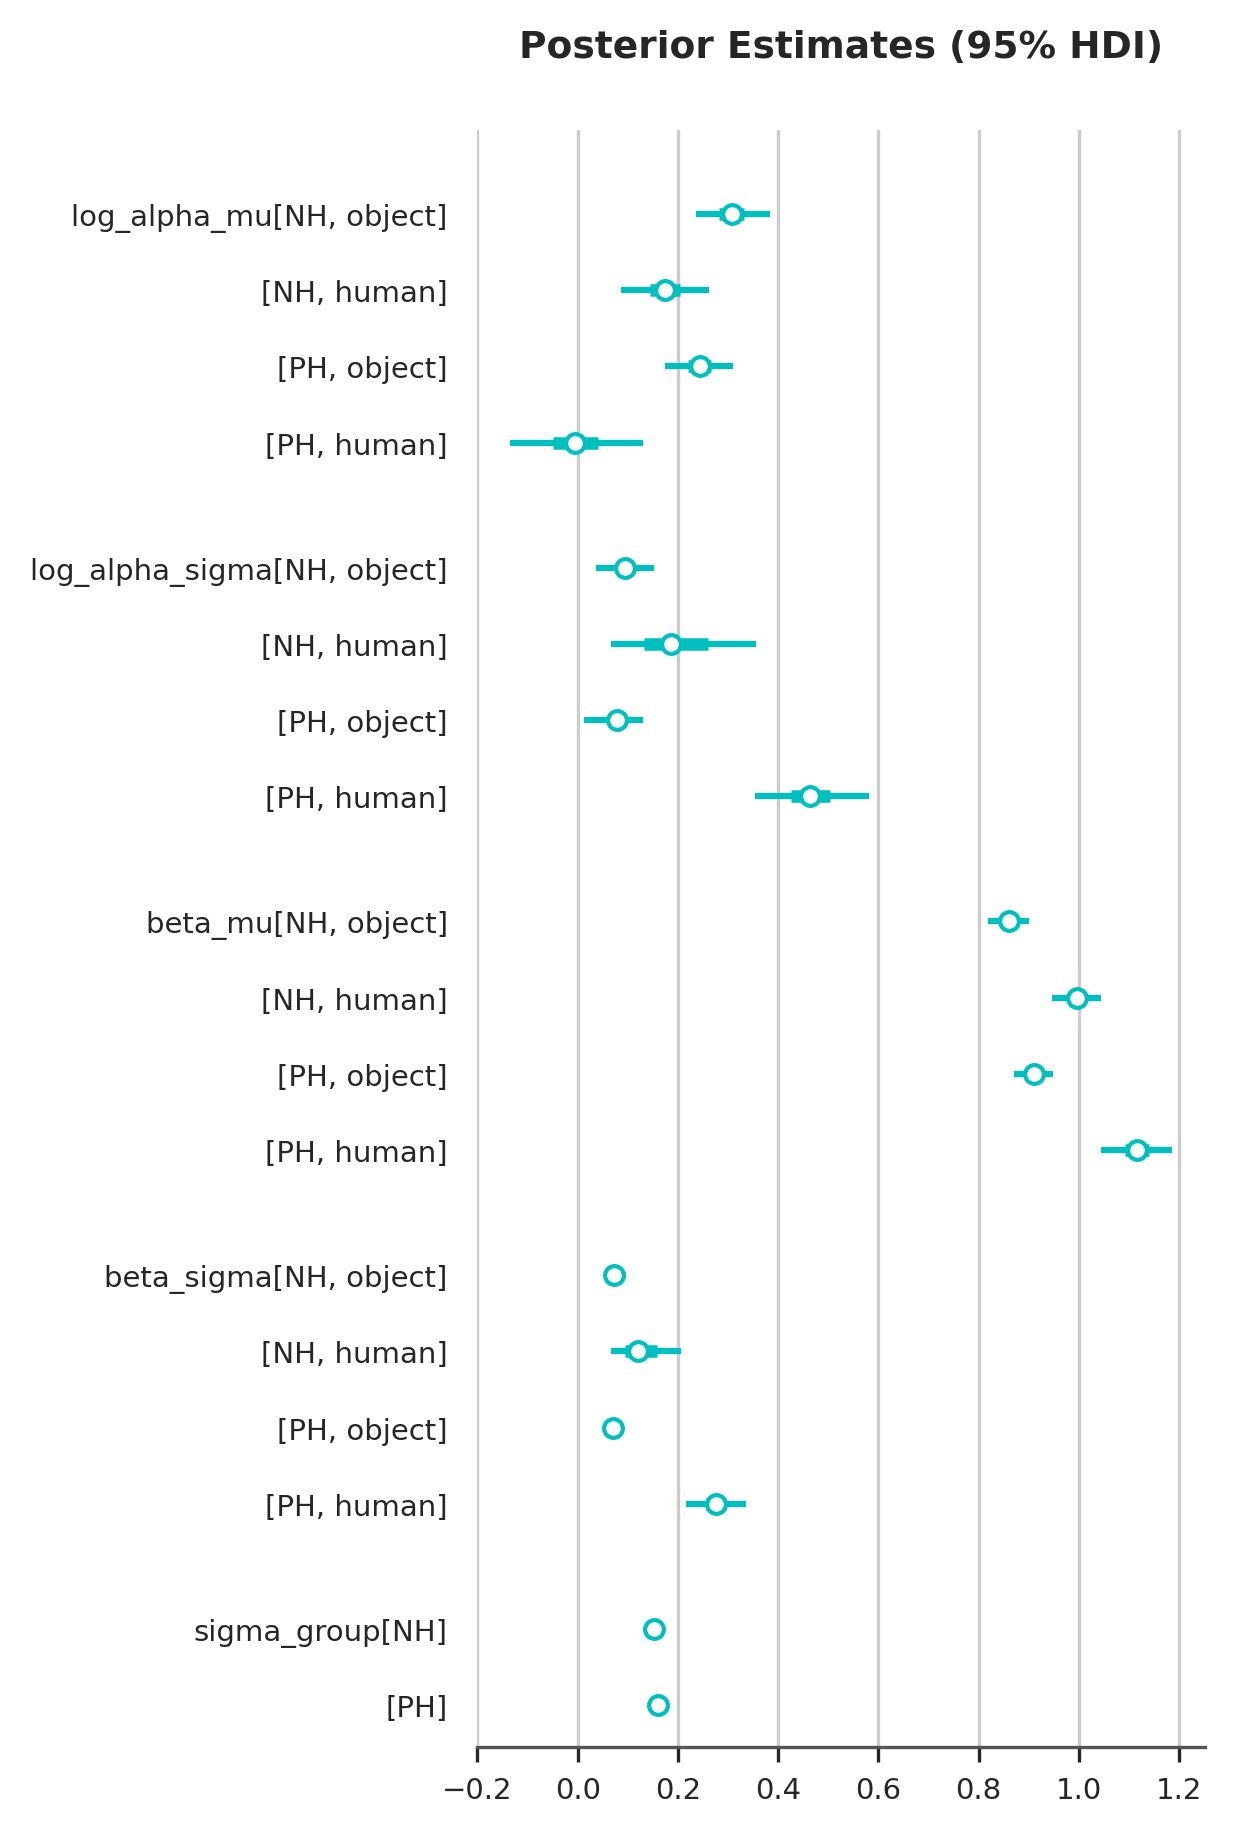

In [ ]:
# Temporarily set smaller font sizes
with plt.rc_context({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
}):
    ax = az.plot_forest(
        idata,
        var_names=main_vars,
        combined=True,
        hdi_prob=0.95,
        colors="C1",
        figsize=(4,6)
    )
    ax[0].set_title("Posterior Estimates (95% HDI)", fontsize=9, y=1.03)
    plt.savefig(plot_dir / "forest.png", dpi=150, bbox_inches="tight")

Plot summary table

In [ ]:
# Group-level bias in scaling (alpha)
summary = az.summary(idata, var_names=main_vars, round_to=4, hdi_prob=0.95)
print(summary)

                               mean      sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
log_alpha_mu[NH, object]     0.3073  0.0372    0.2367     0.3830     0.0008   
log_alpha_mu[NH, human]      0.1744  0.0446    0.0856     0.2616     0.0005   
log_alpha_mu[PH, object]     0.2434  0.0350    0.1751     0.3108     0.0009   
log_alpha_mu[PH, human]     -0.0047  0.0677   -0.1351     0.1311     0.0005   
log_alpha_sigma[NH, object]  0.0942  0.0285    0.0375     0.1527     0.0009   
log_alpha_sigma[NH, human]   0.1995  0.0820    0.0664     0.3561     0.0033   
log_alpha_sigma[PH, object]  0.0793  0.0320    0.0122     0.1312     0.0014   
log_alpha_sigma[PH, human]   0.4654  0.0583    0.3541     0.5808     0.0007   
beta_mu[NH, object]          0.8601  0.0211    0.8177     0.9005     0.0004   
beta_mu[NH, human]           0.9956  0.0251    0.9466     1.0446     0.0003   
beta_mu[PH, object]          0.9094  0.0200    0.8696     0.9479     0.0005   
beta_mu[PH, human]           1.1160  0.0367    1.042

In [ ]:
summary = az.summary(idata, var_names=main_vars, round_to=3, hdi_prob=.95)
summary.reset_index(inplace=True)
summary.rename(columns={"index": "var"})
summary.drop(columns=["mcse_mean", "mcse_sd"], axis=1, inplace=True)

In [ ]:
summary

index   mean     sd  hdi_2.5%  hdi_97.5%   ess_bulk  \
0      log_alpha_mu[NH, object]  0.307  0.037     0.237      0.383   2067.865   
1       log_alpha_mu[NH, human]  0.174  0.045     0.086      0.262   7257.761   
2      log_alpha_mu[PH, object]  0.243  0.035     0.175      0.311   1506.594   
3       log_alpha_mu[PH, human] -0.005  0.068    -0.135      0.131  17259.571   
4   log_alpha_sigma[NH, object]  0.094  0.029     0.038      0.153   1111.214   
5    log_alpha_sigma[NH, human]  0.199  0.082     0.066      0.356    603.432   
6   log_alpha_sigma[PH, object]  0.079  0.032     0.012      0.131    499.554   
7    log_alpha_sigma[PH, human]  0.465  0.058     0.354      0.581   7510.148   
8           beta_mu[NH, object]  0.860  0.021     0.818      0.901   2350.277   
9            beta_mu[NH, human]  0.996  0.025     0.947      1.045   7871.540   
10          beta_mu[PH, object]  0.909  0.020     0.870      0.948   1679.576   
11           beta_mu[PH, human]  1.116  0.037     1.043      1.185  16245.437   
12       beta_sigma[NH, object]  0.074  0.011     0.052      0.096   6046.860   
13        beta_sigma[NH, human]  0.129  0.041     0.067      0.206    689.301   
14       beta_sigma[PH, object]  0.072  0.012     0.053      0.092   2936.847   
15        beta_sigma[PH, human]  0.277  0.031     0.216      0.337   8102.322   
16              sigma_group[NH]  0.152  0.002     0.149      0.156   2296.800   
17              sigma_group[PH]  0.161  0.002     0.158      0.164  13591.299   

     ess_tail  r_hat  
0    4474.255  1.002  
1    9097.600  1.001  
2    2958.278  1.001  
3   12128.493  1.000  
4     847.880  1.003  
5    1380.291  1.003  
6     370.872  1.002  
7    9708.196  1.001  
8    5073.304  1.002  
9   10626.644  1.000  
10   2965.465  1.001  
11  11688.466  1.000  
12   7963.930  1.001  
13   4149.465  1.003  
14   1712.691  1.001  
15   9969.012  1.000  
16   6433.680  1.001  
17  10890.217  1.000

In [ ]:
# Define column widths: first column wider, others narrower
col_widths = [200] + [80] * (len(summary.columns) - 1)  # adjust numbers as needed

fig = go.Figure(data=[go.Table(
    header=dict(
        values=list(summary.columns),
        fill_color="lightblue",
        align="left",
        font=dict(family="Arial Black", color="black", size=14),
        height=30,
        line_color="lightgrey",   # border around header cells
        line_width=0,
    ),
    cells=dict(
        values=[summary[col] for col in summary.columns],
        fill_color="white",
        align="left",
        font=dict(family="Arial",color="black", size=14),
        height=40,
        line_color="lightgrey",   # adds lines between all cell edges
        line_width=1                  # including horizontal row lines
    ),
    columnwidth=col_widths  # <-- apply custom widths
)])

fig.update_layout(
    autosize=False,
    width=sum(col_widths) + 40,  # small padding for borders/margins
    height=800,
    margin=dict(l=10, r=10, t=30, b=10),

)

# To save as a PNG (requires Kaleido)
fig.write_image(plot_dir/"summary_table.png")

# Or just show interactively
fig.show()

In [ ]:
import re
# ---------------------------------------------------------
# 1. Data Parsing & Preparation
# ---------------------------------------------------------

df_plot = summary.copy()

# Parse the index strings
def parse_row_index(index_str):
    match = re.match(r"(.+)\[(.*?)\]", index_str)
    if match:
        param_raw = match.group(1)
        conditions = match.group(2).split(',')
        group = conditions[0].strip()
        stimulus = conditions[1].strip() if len(conditions) > 1 else "—" 
        return param_raw, group, stimulus
    return index_str, "", ""

parsed_data = [parse_row_index(x) for x in df_plot['index']]
df_plot['Parameter Raw'] = [x[0] for x in parsed_data]
df_plot['Group'] = [x[1] for x in parsed_data]
df_plot['Stimulus'] = [x[2] for x in parsed_data]

# --- Define Logic Order for Sorting ---
param_order = [
    'log_alpha_mu', 'beta_mu',               # Main effects
    'log_alpha_sigma', 'beta_sigma',         # Variabilities
    'sigma_group'
]

# 1. Convert to Categorical to define sort order
df_plot['Parameter Raw'] = pd.Categorical(df_plot['Parameter Raw'], categories=param_order, ordered=True)

# 2. Sort the dataframe
df_plot = df_plot.sort_values(by=['Parameter Raw', 'Group', 'Stimulus'])

# 3. *** CRITICAL FIX ***: Convert back to string so .map() and .fillna() work
df_plot['Parameter Raw'] = df_plot['Parameter Raw'].astype(str)

# --- MAPPING & FORMATTING ---
param_map = {
    'log_alpha_mu': '<b>Log Alpha (μ)</b><br><span style="font-size:12px; color:gray"><i>(Scaling)</i></span>',
    'beta_mu': '<b>Beta (μ)</b><br><span style="font-size:12px; color:gray"><i>(Compression)</i></span>',
    'log_alpha_sigma': '<b>Log Alpha (σ)</b><br><span style="font-size:12px; color:gray"><i>(Var.)</i></span>',
    'beta_sigma': '<b>Beta (σ)</b><br><span style="font-size:12px; color:gray"><i>(Var.)</i></span>',
    'sigma_group': '<b>Group Sigma</b>'
}

# Now this works because Parameter Raw is just a standard string column again
df_plot['Parameter'] = df_plot['Parameter Raw'].map(param_map).fillna(df_plot['Parameter Raw'])

# Create combined HDI string
df_plot['95% HDI'] = df_plot.apply(lambda row: f"[{row['hdi_2.5%']:.3f}, {row['hdi_97.5%']:.3f}]", axis=1)

# Format numbers
df_plot['Mean'] = df_plot['mean'].map('{:.3f}'.format)
df_plot['SD'] = df_plot['sd'].map('{:.3f}'.format)

# Copy to final df
df_final = df_plot[['Parameter', 'Group', 'Stimulus', 'Mean', 'SD', '95% HDI']].copy()

# ---------------------------------------------------------
# 2. Logic to "Merge" Cells (Masking Repeats)
# ---------------------------------------------------------

df_final['Param_Display'] = df_final['Parameter'].astype(str)
df_final['Group_Display'] = df_final['Group'].astype(str)

row_line_widths = [1] * len(df_final)
row_line_colors = ['lightgrey'] * len(df_final)

previous_param = None
previous_group = None

for i in range(len(df_final)):
    current_param = df_final.iloc[i]['Parameter']
    current_group = df_final.iloc[i]['Group']
    
    # Check if we are at the last row of the dataframe
    is_last_row = (i == len(df_final) - 1)
    
    # Check if next row is a new parameter (to draw a thick line)

    # Masking Text logic
    if current_param == previous_param:
        df_final.iloc[i, df_final.columns.get_loc('Param_Display')] = ''
        
        if current_group == previous_group:
            df_final.iloc[i, df_final.columns.get_loc('Group_Display')] = ''
            
    previous_param = current_param
    previous_group = current_group

# ---------------------------------------------------------
# 3. Plotting
# ---------------------------------------------------------

col_widths = [120, 60, 80, 60, 60, 120]

fig = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Parameter</b>", "<b>Group</b>", "<b>Stimulus</b>", "<b>Mean</b>", "<b>SD</b>", "<b>95% HDI</b>"],
        fill_color="lightblue",
        align=["left", "left", "left", "center", "center", "center"],
        font=dict(family="Arial", color="black", size=14),
        height=35,
        line_color="black",
        line_width=0,
    ),
    cells=dict(
        values=[
            df_final['Param_Display'], 
            df_final['Group_Display'], 
            df_final['Stimulus'], 
            df_final['Mean'], 
            df_final['SD'], 
            df_final['95% HDI']
        ],
        fill_color="white",
        align=["left", "left", "left", "center", "center", "center"],
        font=dict(family="Arial", color="black", size=13),
        height=40,
        line=dict(width=1, color=row_line_colors) 
    ),
    columnwidth=col_widths
)])

fig.update_layout(
    autosize=False,
    width=sum(col_widths) + 20,
    height=850,
    margin=dict(l=10, r=10, t=30, b=10)
)
fig.write_image(plot_dir/"summary_table_clean.png")
fig.show()

## Hypothesis testing

A theoretical investigation based on summary mean values into the overestimation of human numerosity in parkinsons patients.

In [ ]:
idata.posterior["log_alpha_mu"]

<xarray.DataArray 'log_alpha_mu' (chain: 4, draw: 4000, group: 2, entity_type: 2)> Size: 512kB
array([[[[ 0.32920574,  0.22968274],
         [ 0.25301363,  0.02043169]],

        [[ 0.26653039,  0.18164719],
         [ 0.2589328 , -0.09188778]],

        [[ 0.30883457,  0.15804761],
         [ 0.26677572,  0.16398844]],

        ...,

        [[ 0.34379474,  0.17733575],
         [ 0.26083966, -0.10823013]],

        [[ 0.36527408,  0.13428842],
         [ 0.25607904,  0.05934811]],

        [[ 0.24078087,  0.17819062],
         [ 0.26409998, -0.03120243]]],

...

       [[[ 0.22836786,  0.17359534],
         [ 0.23806297,  0.08843541]],

        [[ 0.22950239,  0.22682391],
         [ 0.22607688, -0.11676036]],

        [[ 0.22482465,  0.2233381 ],
         [ 0.22376637, -0.1233209 ]],

        ...,

        [[ 0.3243371 ,  0.10231278],
         [ 0.22463957, -0.04141573]],

        [[ 0.28117659,  0.34040785],
         [ 0.2331666 ,  0.057187  ]],

        [[ 0.2240164 ,  0.29243556],
         [ 0.26769892, -0.0584196 ]]]], shape=(4, 4000, 2, 2))
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 32kB 0 1 2 3 4 5 ... 3994 3995 3996 3997 3998 3999
  * group        (group) <U2 16B 'NH' 'PH'
  * entity_type  (entity_type) <U6 48B 'object' 'human'

In [ ]:
from itertools import combinations
import pandas as pd
import numpy as np
import arviz as az

def posterior_contrast(
    idata,
    var_name,
    cond_a,
    cond_b,
    hdi_prob=0.95
):
    """
    Compute posterior contrast between two conditions.

    cond_a / cond_b are dicts of coordinates, e.g.
    {"group": "PH", "entity_type": "human"}
    """
    a = idata.posterior[var_name].sel(**cond_a).values
    b = idata.posterior[var_name].sel(**cond_b).values

    cond_a_label = f"{cond_a['group']} | {cond_a['entity_type']}"
    cond_b_label = f"{cond_b['group']} | {cond_b['entity_type']}"

    diff = a - b
    diff_flat = diff.reshape(-1)

    hdi = az.hdi(diff_flat, hdi_prob=hdi_prob)

    return {
        "variable": var_name,
        "contrast": f"{cond_a_label} - {cond_b_label}",
        "mean": diff_flat.mean(),
        "sd": diff_flat.std(),
        "hdi_low": hdi[0],
        "hdi_high": hdi[1],
        "p_gt_0": (diff_flat > 0).mean(),
        "p_lt_0": (diff_flat < 0).mean(),
        "hdi_excludes_0": not (hdi[0] <= 0 <= hdi[1]),
    }

def all_pairwise_contrasts(idata, var_names, dims):
    """
    Compute all pairwise contrasts across multiple posterior variables.

    Parameters
    ----------
    idata : arviz.InferenceData
        The inference data object.
    var_names : list of str
        List of variable names in idata.posterior to compute contrasts for.
    dims : dict
        Dictionary mapping dimension names to their coordinate values,
        e.g., {"group": ["NH", "PH"], "entity_type": ["object", "human"]}

    Returns
    -------
    pd.DataFrame
        A DataFrame with one row per contrast per variable.
    """
    # Build all condition combinations
    dim_keys = list(dims.keys())
    coord_values = list(dims.values())
    conditions = [
        dict(zip(dim_keys, values))
        for values in np.array(np.meshgrid(*coord_values)).T.reshape(-1, len(dim_keys))
    ]

    rows = []
    for var_name in var_names:
        # Optional: validate that var_name exists and has required dims
        if var_name not in idata.posterior:
            raise KeyError(f"Variable '{var_name}' not found in idata.posterior")
        for a, b in combinations(conditions, 2):
            rows.append(
                posterior_contrast(
                    idata,
                    var_name=var_name,
                    cond_a=a,
                    cond_b=b,
                    hdi_prob=0.95
                )
            )
    return pd.DataFrame(rows)

dims = {
    "group": idata.posterior["log_alpha_mu"].coords["group"].values.tolist(),
    "entity_type": idata.posterior["log_alpha_mu"].coords["entity_type"].values.tolist(),
}

# Now pass a list of variables
df_all = all_pairwise_contrasts(
    idata,
    var_names=["log_alpha_mu", "beta_mu", "log_alpha_sigma", "beta_sigma"],
    dims=dims
)

df_all

variable                   contrast      mean        sd   hdi_low  \
0      log_alpha_mu   NH | object - NH | human  0.132907  0.057594  0.019321   
1      log_alpha_mu  NH | object - PH | object  0.063945  0.050870 -0.035039   
2      log_alpha_mu   NH | object - PH | human  0.312030  0.077752  0.158060   
3      log_alpha_mu   NH | human - PH | object -0.068963  0.056577 -0.178537   
4      log_alpha_mu    NH | human - PH | human  0.179122  0.081128  0.017391   
5      log_alpha_mu   PH | object - PH | human  0.248085  0.076129  0.094027   
6           beta_mu   NH | object - NH | human -0.135484  0.032751 -0.199834   
7           beta_mu  NH | object - PH | object -0.049367  0.028883 -0.105739   
8           beta_mu   NH | object - PH | human -0.255965  0.042445 -0.341894   
9           beta_mu   NH | human - PH | object  0.086117  0.032100  0.025064   
10          beta_mu    NH | human - PH | human -0.120481  0.044821 -0.204316   
11          beta_mu   PH | object - PH | human -0.206598  0.041894 -0.289370   
12  log_alpha_sigma   NH | object - NH | human -0.105257  0.085080 -0.276729   
13  log_alpha_sigma  NH | object - PH | object  0.014881  0.043288 -0.067540   
14  log_alpha_sigma   NH | object - PH | human -0.371159  0.064978 -0.497417   
15  log_alpha_sigma   NH | human - PH | object  0.120138  0.088143 -0.028414   
16  log_alpha_sigma    NH | human - PH | human -0.265903  0.100459 -0.445875   
17  log_alpha_sigma   PH | object - PH | human -0.386041  0.065857 -0.514895   
18       beta_sigma   NH | object - NH | human -0.055062  0.041703 -0.136710   
19       beta_sigma  NH | object - PH | object  0.002061  0.016330 -0.028477   
20       beta_sigma   NH | object - PH | human -0.203425  0.032571 -0.265923   
21       beta_sigma   NH | human - PH | object  0.057122  0.042183 -0.010298   
22       beta_sigma    NH | human - PH | human -0.148364  0.050668 -0.244091   
23       beta_sigma   PH | object - PH | human -0.205486  0.032583 -0.270188   

    hdi_high    p_gt_0    p_lt_0  hdi_excludes_0  
0   0.245095  0.987875  0.012125            True  
1   0.164194  0.895875  0.104125           False  
2   0.462794  1.000000  0.000000            True  
3   0.045327  0.110250  0.889750           False  
4   0.336862  0.985750  0.014250            True  
5   0.394126  0.999437  0.000562            True  
6  -0.071185  0.000125  0.999875            True  
7   0.007530  0.042375  0.957625           False  
8  -0.175076  0.000000  1.000000            True  
9   0.150597  0.996750  0.003250            True  
10 -0.027390  0.004000  0.996000            True  
11 -0.125323  0.000000  1.000000            True  
12  0.034223  0.091313  0.908687           False  
13  0.097654  0.664813  0.335188           False  
14 -0.246661  0.000000  1.000000            True  
15  0.293526  0.940063  0.059937           False  
16 -0.060735  0.005188  0.994812            True  
17 -0.259522  0.000063  0.999938            True  
18  0.012660  0.055188  0.944813           False  
19  0.032165  0.569438  0.430563           False  
20 -0.137670  0.000000  1.000000            True  
21  0.140629  0.956000  0.044000           False  
22 -0.048513  0.001937  0.998062            True  
23 -0.141688  0.000063  0.999938            True

vars: ['log_alpha_mu']


Empty DataFrame
Columns: []
Index: []

## Latent Trajectories

In [ ]:
main_vars

['log_alpha_mu', 'log_alpha_sigma', 'beta_mu', 'beta_sigma', 'sigma_group']

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_70514/926140632.py:107: UserWarning:

The figure layout has changed to tight



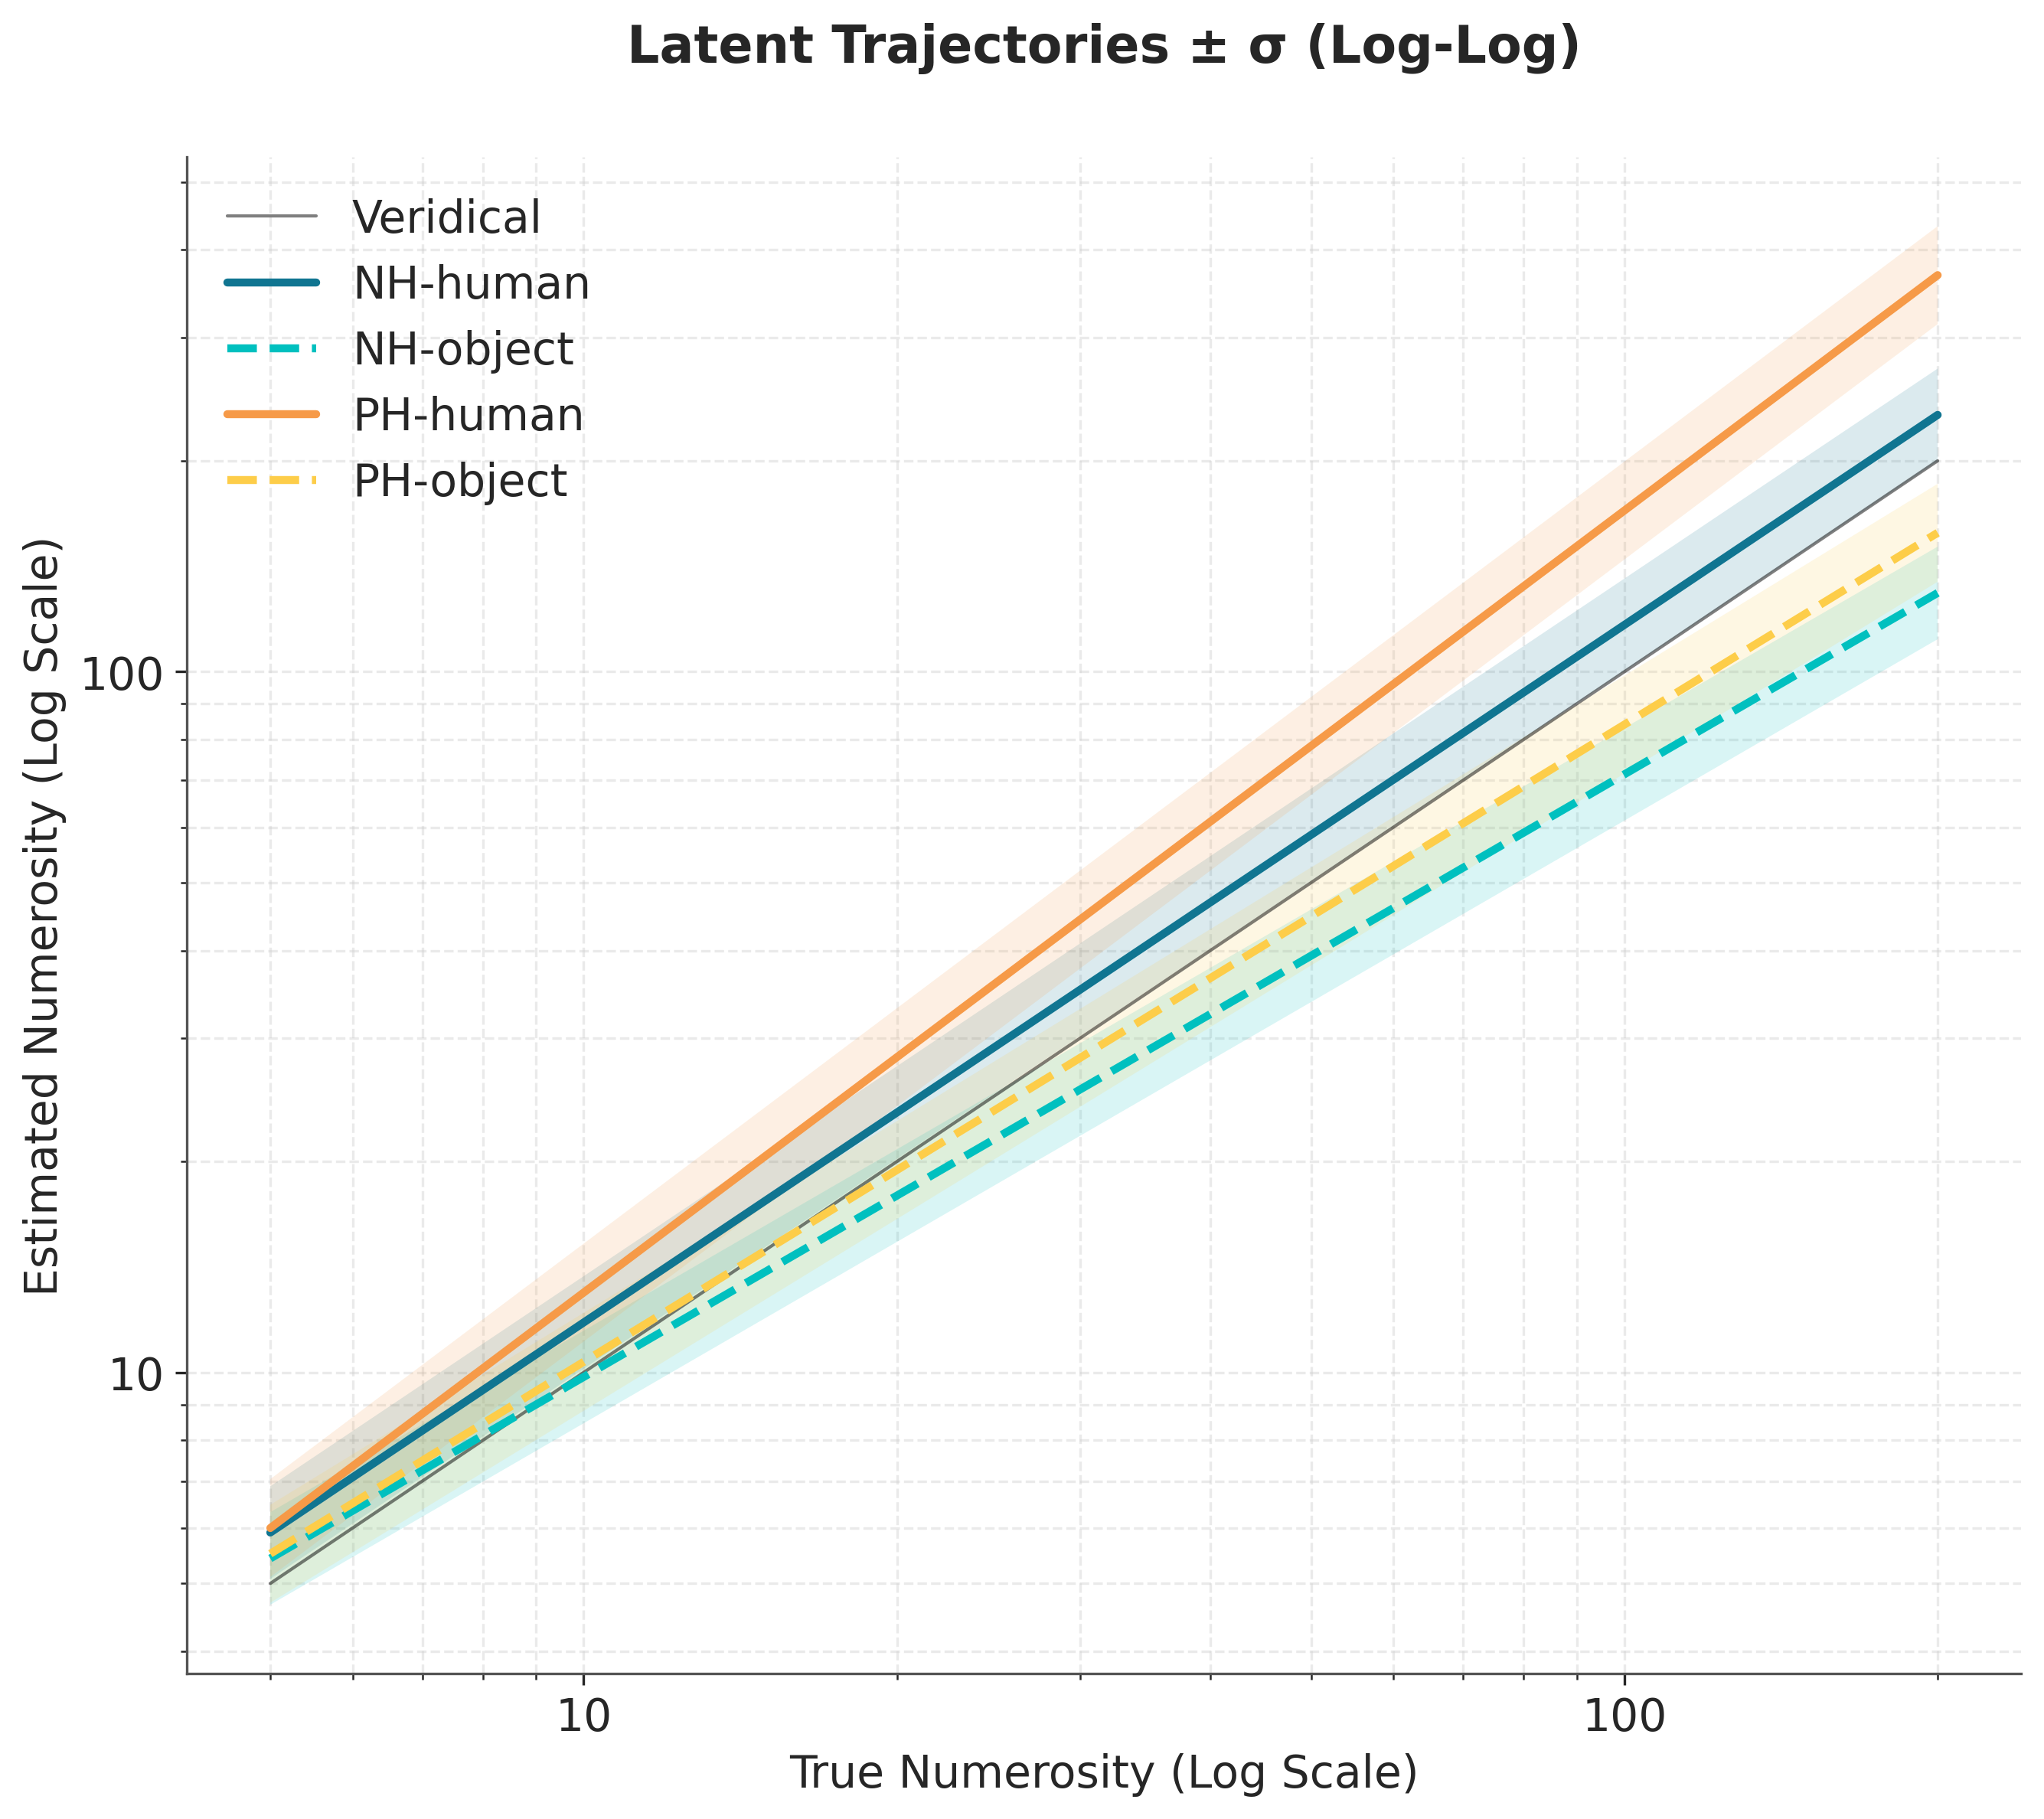

/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_70514/926140632.py:107: UserWarning:

The figure layout has changed to tight



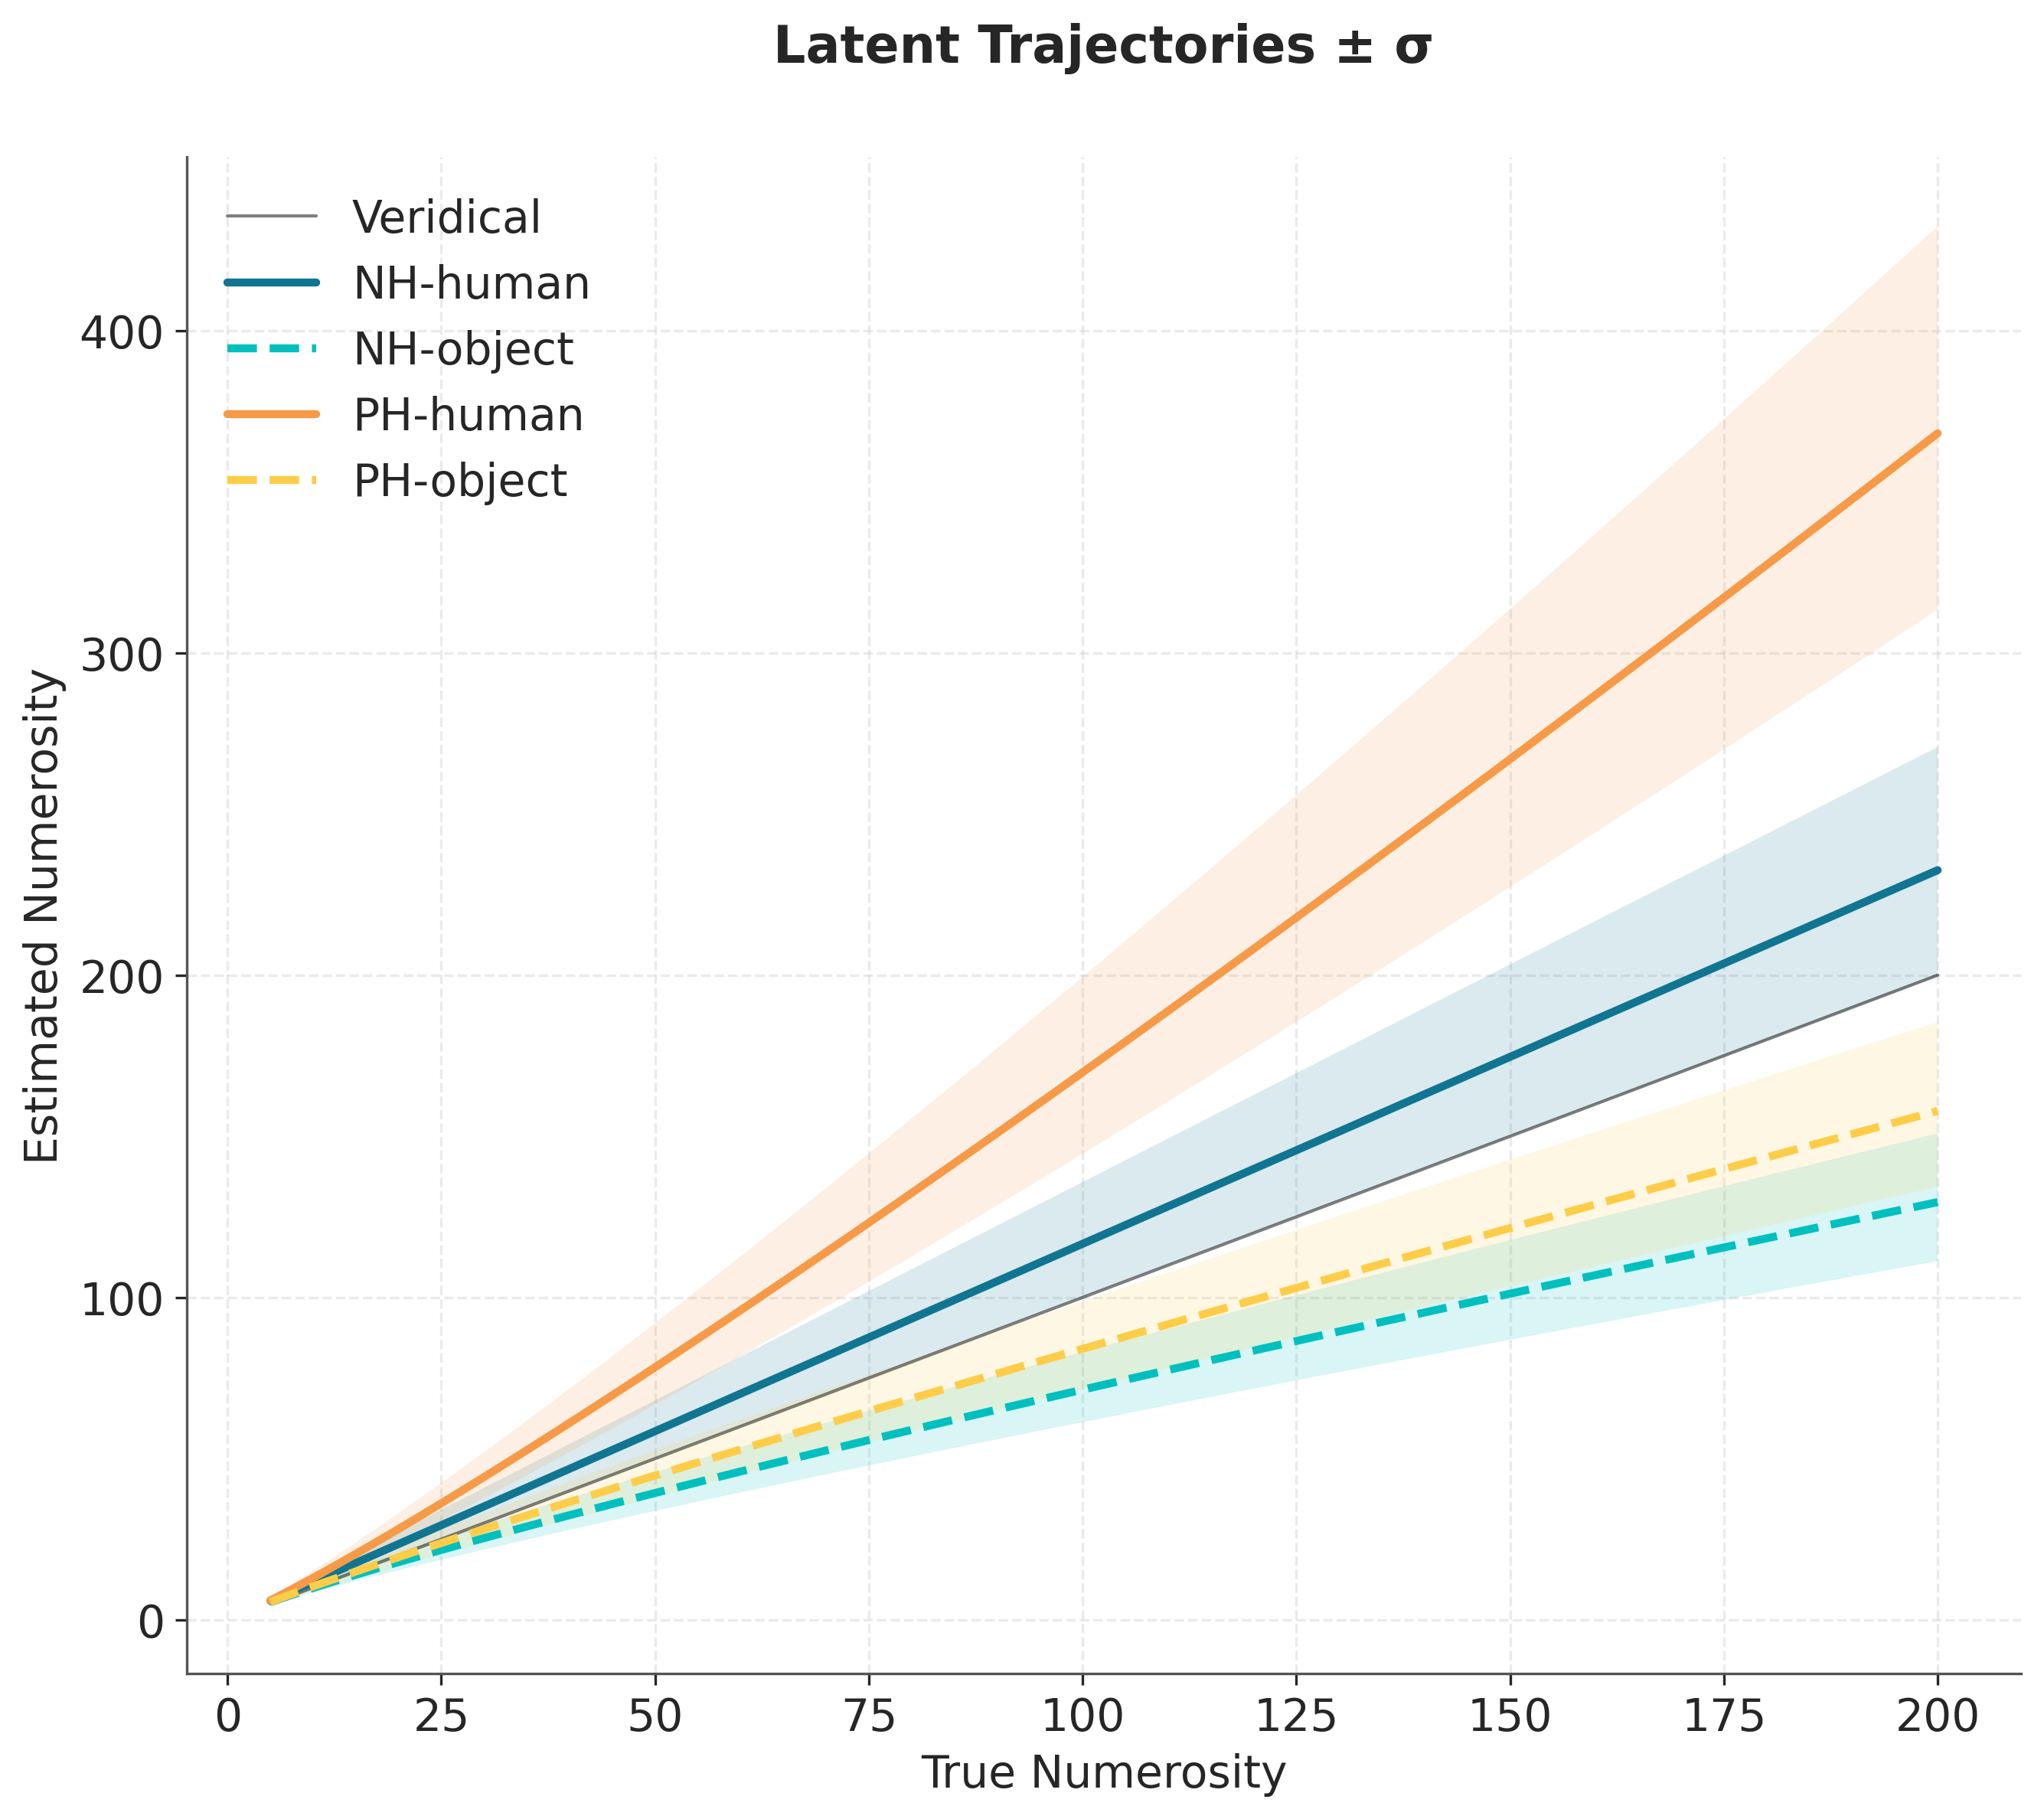

In [ ]:
# ------------------------------------------------------------------
# 1. Curve Calculation
# ------------------------------------------------------------------
def get_prediction(n_range, log_alpha, beta):
    """
    Returns the median predicted response.
    y = exp(log_alpha) * n^beta
    """
    alpha = np.exp(log_alpha)
    return alpha * (n_range ** beta)

# ------------------------------------------------------------------
# 2. Plotting Function
# ------------------------------------------------------------------
def plot_psychophysics_with_sigma(idata, log_log_space=False):
    
    # --- A. Extract Means ---
    post = idata.posterior
    # Parameters defining the curve
    log_alpha_means = post["log_alpha_mu"].mean(dim=["chain", "draw"])
    beta_means = post["beta_mu"].mean(dim=["chain", "draw"])
    
    # Parameter defining the variance (NOISE)
    sigma_means = post["sigma_group"].mean(dim=["chain", "draw"])
    
    # --- B. Setup Range ---
    if log_log_space:
        n_range = np.geomspace(5, 200, 100)
    else:
        n_range = np.linspace(5, 200, 100)

    plt.figure(figsize=(9, 8))

    # --- Veridical reference ---
    plt.plot(n_range, n_range, "k-", linewidth=1, alpha=0.5, label="Veridical")

    # --- Setup Colors ---
    colors = {
        ("NH", "human"): "C0",
        ("NH", "object"): "C1",
        ("PH", "human"): "C2", 
        ("PH", "object"): "C3",
    }
    linestyles = {"human": "-", "object": "--"}

    # --- C. Plotting Loop ---
    groups = ["NH", "PH"]
    entities = ["human", "object"]

    for group in groups:
        # Get the noise level for this group
        # (The model assumes Sigma depends on Group, but not Entity)
        sigma_val = sigma_means.sel(group=group).item()
        
        for entity in entities:
            # Get curve parameters
            la_val = log_alpha_means.sel(group=group, entity_type=entity).item()
            b_val = beta_means.sel(group=group, entity_type=entity).item()

            # 1. Calculate the Median Curve
            y_pred = get_prediction(n_range, la_val, b_val)
            
            # 2. Calculate Variance Bounds (1 Standard Deviation)
            # Since model is LogNormal, +1 sigma in log space becomes * exp(sigma) in linear
            y_upper = y_pred * np.exp(sigma_val)
            y_lower = y_pred / np.exp(sigma_val)
            
            # 3. Plot the Line
            label = f"{group}-{entity}"
            plt.plot(
                n_range, 
                y_pred,
                color=colors[(group, entity)],
                linestyle=linestyles[entity],
                linewidth=2.5,
                label=label
            )
            
            # 4. Plot the Variance (Shaded Region)
            plt.fill_between(
                n_range,
                y_lower,
                y_upper,
                color=colors[(group, entity)],
                alpha=0.15, # Low opacity to see overlaps
                edgecolor=None
            )

    # --- Formatting ---
    if log_log_space:
        plt.xscale("log")
        plt.yscale("log")
        from matplotlib.ticker import ScalarFormatter
        plt.gca().xaxis.set_major_formatter(ScalarFormatter())
        plt.gca().yaxis.set_major_formatter(ScalarFormatter())
        plt.xlabel("True Numerosity (Log Scale)")
        plt.ylabel("Estimated Numerosity (Log Scale)")
        plt.title("Latent Trajectories ± σ (Log-Log)", y=1.05)
    else:
        plt.xlabel("True Numerosity")
        plt.ylabel("Estimated Numerosity")
        plt.title("Latent Trajectories ± σ", y=1.05)

    
    plt.legend()
    plt.grid(True, which="both", linestyle='--', alpha=0.4)
    plt.tight_layout()
    if log_log_space:
        plt.savefig(plot_dir/"lat_traj_log.png")
    else:
        plt.savefig(plot_dir/"lat_traj.png")
    plt.show()

# Run
plot_psychophysics_with_sigma(idata=idata, log_log_space=True)
plot_psychophysics_with_sigma(idata=idata, log_log_space=False)

Aggregated posteriors

Detected entity labels: ['object' 'human']


/var/folders/38/7bfzlz1n56s9bgpgqxr75fzh0000gn/T/ipykernel_74603/122877615.py:93: UserWarning:

The figure layout has changed to tight



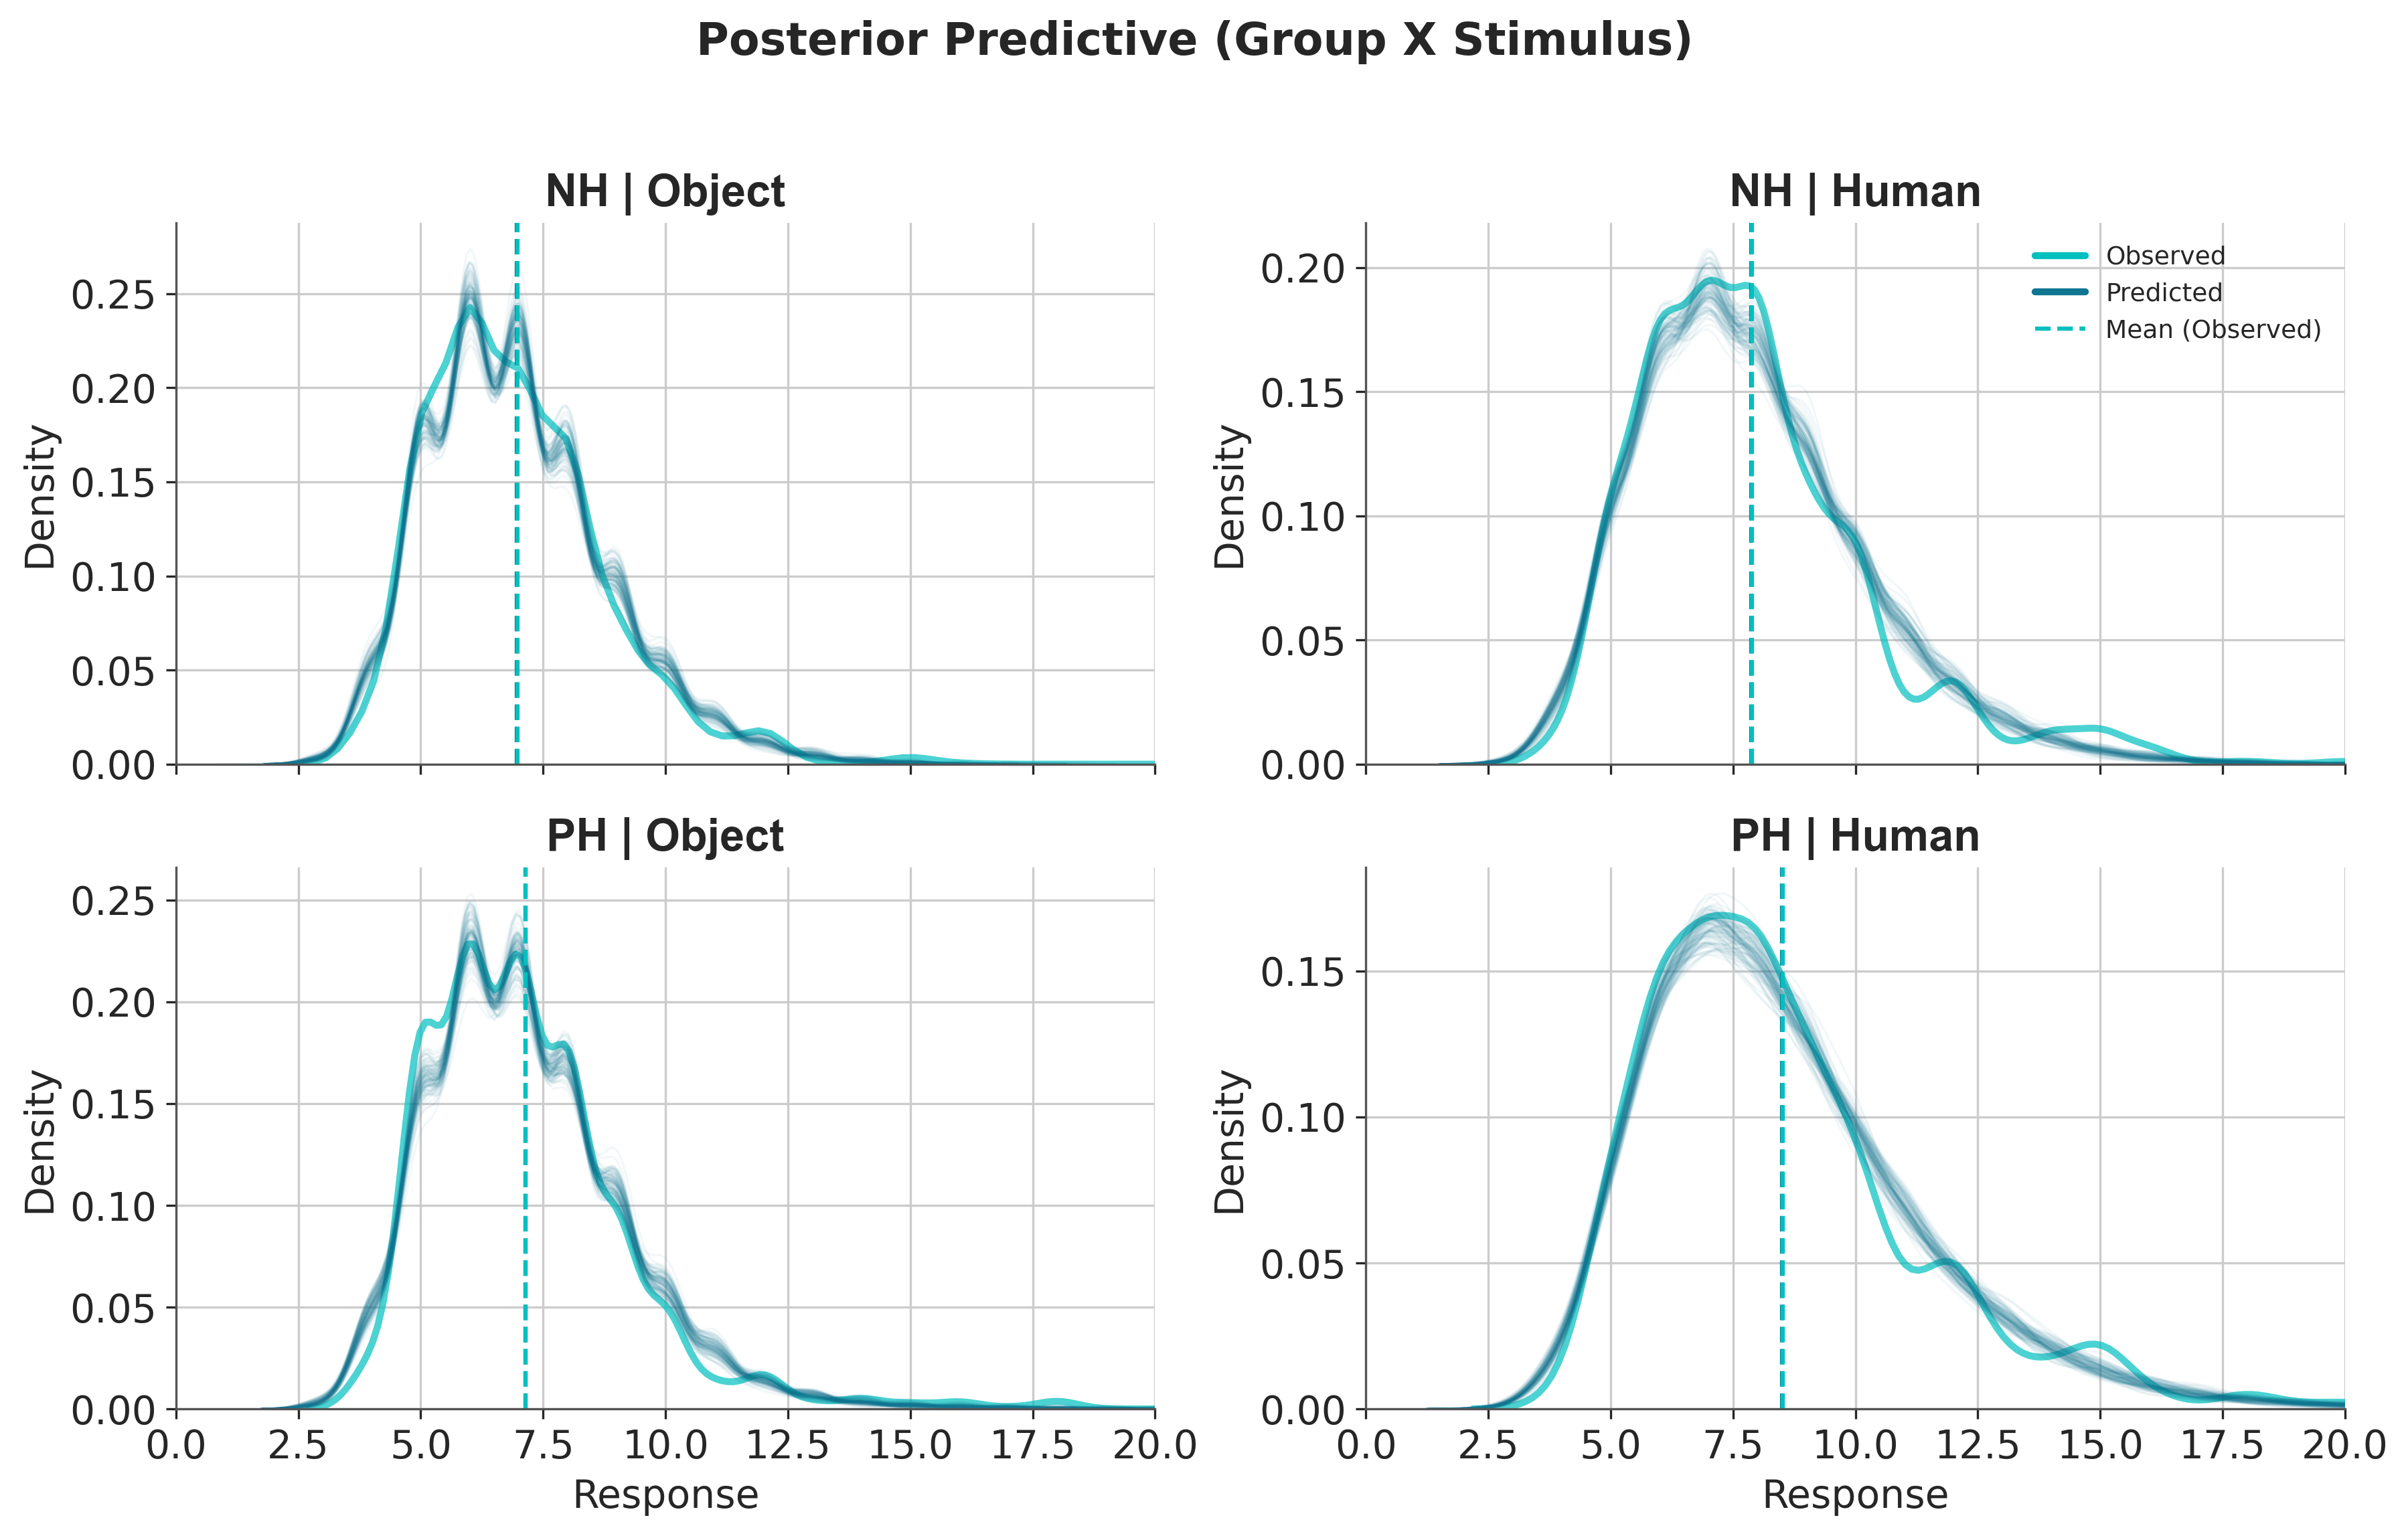

In [ ]:
from matplotlib.lines import Line2D

# --- 1. PREPARE MAPPING ---
unique_entities = X["entity"].unique()
print(f"Detected entity labels: {unique_entities}")

if "human" in unique_entities or "Human" in unique_entities:
    entity_map = {
        0: "object",  # adjust casing if needed
        1: "human"
    }
else:
    entity_map = {0: 0, 1: 1}

# Extract posterior predictive samples (keep full shape)
y_pred_all = idata.posterior_predictive.y_pred.values  # shape: (n_chains, n_draws, n_trials)
n_chains, n_draws, n_trials = y_pred_all.shape

# Optionally subsample draws for speed/clarity (e.g., 100 draws total)
n_subsample = 100
rng = np.random.default_rng(42)
draw_indices = rng.choice(n_chains * n_draws, size=n_subsample, replace=False)
y_pred_subsample = y_pred_all.reshape(n_chains * n_draws, n_trials)[draw_indices]  # (n_subsample, n_trials)

# Ensure groups are sorted consistently
groups = sorted(X["s_param_ph"].unique())
group_labels = ["NH", "PH"]

# --- 2. PLOT ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
fig.suptitle("Posterior Predictive (Group X Stimulus)", fontsize=16)

color_pred = "C0"  # Blue (for predicted)
color_obs = "C1"   # Orange (for observed)
color_true = "C2"  # For presented numerosity mean

for i, group in enumerate(groups):
    for j, ent_int in enumerate([0, 1]):
        ax = axes[i, j]
        
        df_ent_value = entity_map[ent_int]
        mask = (X["s_param_ph"] == group) & (X["entity"] == df_ent_value)
        
        if mask.sum() == 0:
            ax.text(0.5, 0.5, f"NO DATA\nGroup: {group_labels[i]}\nEntity: {df_ent_value}", 
                    ha='center', va='center', color='red')
            continue
            
        # Observed responses
        obs_subset = y_obs[mask] if isinstance(y_obs, np.ndarray) else y_obs.values[mask]
        
        # Presented numerosity (assumed to be in X)
        presented_num = X.loc[mask, "Presented_numerosity"]
        mean_presented = presented_num.mean()

        # Plot observed KDE
        sns.kdeplot(
            obs_subset, 
            color=color_obs,
            linewidth=2.5, 
            alpha=0.7,
            label="Observed", 
            ax=ax
        )
        
        # Plot each posterior predictive draw as a separate KDE (faint lines)
        for draw in y_pred_subsample[:, mask]:
            sns.kdeplot(
                draw,
                color=color_pred,
                alpha=0.05,          # very transparent
                linewidth=0.8,
                ax=ax
            )
        
        # Add mean lines
        print(f"y_pred subsample, max {y_pred_subsample[:, mask].max()}, {y_pred_subsample[:, mask].min()}")
        print(f"obs_subset, max {obs_subset.max()} min {obs_subset.min()}")
        print(f"y_pred subsample mean {np.mean(y_pred_subsample[:, mask])} obs_subset mean {np.mean(obs_subset)}")
        ax.axvline(np.mean(y_pred_subsample[:, mask]), color=color_pred, linestyle="--", linewidth=1.5, label="Mean (Predicted)")
        ax.axvline(np.mean(obs_subset), color=color_obs, linestyle="--", linewidth=1.5, label="Mean (Observed)")

        # Labels
        ent_label = "Human" if ent_int == 1 else "Object"
        ax.set_title(f"{group_labels[i]} | {ent_label}", fontdict=dict(family="Arial"))
        ax.set_xlabel("Response")
        ax.set_xlim(0,20)

# Only add legend once (top-left)
legend_elements = [
    Line2D([0], [0], color=color_obs, lw=2.5, label='Observed'),
    Line2D([0], [0], color=color_pred, lw=2.5, label='Predicted'),  # representative predicted line
    Line2D([0], [0], color=color_obs, lw=1.5, ls='--', label='Mean (Observed)'),
    Line2D([0], [0], color=color_pred, lw=1.5, ls='--', label='Mean (Predicted)'),
]
axes[0, 1].legend(handles=legend_elements, fontsize=9)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig(plot_dir/"ppc_group.png")

# Subject level parameters